In [2]:
#!pip install transformers scikit-learn pandas matplotlib tqdm

# 2. IMPORTS
import pandas as pd
import torch
from torch import nn
from transformers import AutoTokenizer, AutoModel, get_scheduler
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from torch.utils.data import Dataset, DataLoader

# Case of the SAMPL dataset

In [ ]:
chemin_1 = "SAMPL(5).csv"
df_1 = pd.read_csv(chemin_1)


display(df_1.head(10))

,iupac,smiles,expt,calc
0,"4-methoxy-N,N-dimethyl-benzamide",CN(C)C(=O)c1ccc(cc1)OC,-11.01,-9.625
1,methanesulfonyl chloride,CS(=O)(=O)Cl,-4.87,-6.219
2,3-methylbut-1-ene,CC(C)C=C,1.83,2.452
3,2-ethylpyrazine,CCc1cnccn1,-5.45,-5.809
4,heptan-1-ol,CCCCCCCO,-4.21,-2.917
5,"3,5-dimethylphenol",Cc1cc(cc(c1)O)C,-6.27,-5.444
6,"2,3-dimethylbutane",CC(C)C(C)C,2.34,2.468
7,2-methylpentan-2-ol,CCCC(C)(C)O,-3.92,-2.779
8,"1,2-dimethylcyclohexane",C[C@@H]1CCCC[C@@H]1C,1.58,1.685
9,butan-2-ol,CC[C@H](C)O,-4.62,-3.145


Epoch 1 | Train Loss: 15.1670 | Test Loss: 11.6953 | R2: 0.3448
Epoch 2 | Train Loss: 8.0147 | Test Loss: 8.4766 | R2: 0.4733
Epoch 3 | Train Loss: 6.1432 | Test Loss: 6.3328 | R2: 0.6000
Epoch 4 | Train Loss: 5.1594 | Test Loss: 5.3598 | R2: 0.6490
Epoch 5 | Train Loss: 4.1829 | Test Loss: 4.9175 | R2: 0.6698
Epoch 6 | Train Loss: 3.2430 | Test Loss: 4.0745 | R2: 0.7268
Epoch 7 | Train Loss: 3.0849 | Test Loss: 3.8942 | R2: 0.7375
Epoch 8 | Train Loss: 2.8093 | Test Loss: 3.6183 | R2: 0.7570
Epoch 9 | Train Loss: 2.2989 | Test Loss: 3.2329 | R2: 0.7823
Epoch 10 | Train Loss: 2.0919 | Test Loss: 3.1092 | R2: 0.7905
Epoch 11 | Train Loss: 1.8790 | Test Loss: 3.1193 | R2: 0.7927
Epoch 12 | Train Loss: 1.8619 | Test Loss: 2.8835 | R2: 0.8070
Epoch 13 | Train Loss: 2.5562 | Test Loss: 3.0066 | R2: 0.8081
Epoch 14 | Train Loss: 1.4086 | Test Loss: 2.9178 | R2: 0.8046
Epoch 15 | Train Loss: 1.3549 | Test Loss: 2.8704 | R2: 0.8173
Epoch 16 | Train Loss: 1.2206 | Test Loss: 2.7526 | R2: 0.8195

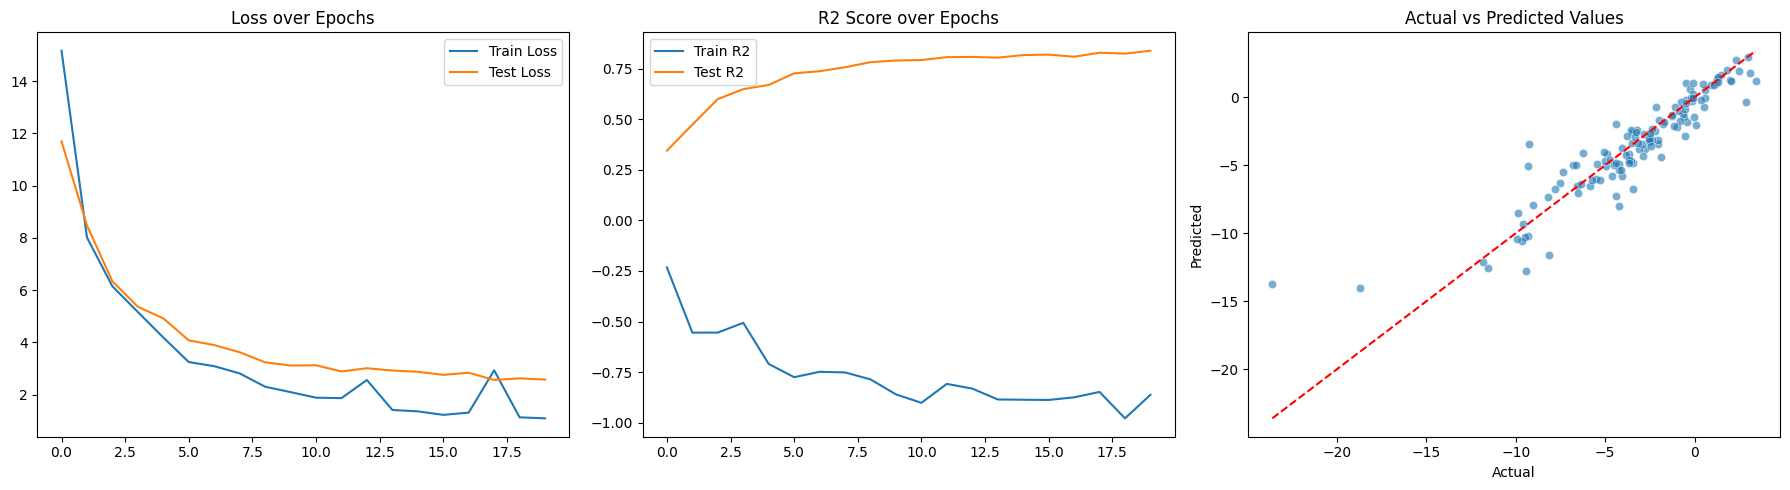

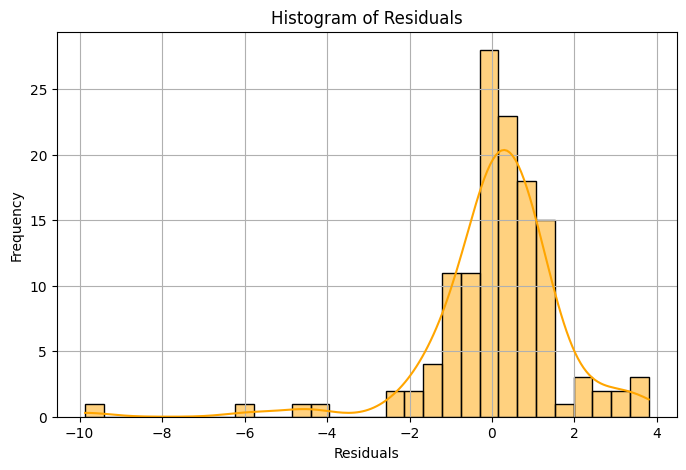

📊 Residual Standard Error (RSE) on all data: nan


<ipython-input-6-e9bc72d836ea>:180: RuntimeWarning: invalid value encountered in sqrt
  rse = np.sqrt(np.sum(residuals**2) / (n - p))


In [ ]:
# 1. Load the dataset
data = pd.read_csv("SAMPL(5).csv")  # 🔁 Put the path to your CSV file

# 2. Tokenizer and ChemBERTa model
tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
bert_model = AutoModel.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")

# 3. Custom Dataset
class SMILESDataset(Dataset):
    def __init__(self, smiles, targets, tokenizer, max_length=128):
        self.smiles = smiles
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, idx):
        smile = str(self.smiles[idx])
        target = self.targets[idx]
        encoding = self.tokenizer(smile, padding='max_length', truncation=True,
                                  max_length=self.max_length, return_tensors='pt')
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'target': torch.tensor(target, dtype=torch.float)
        }

# 4. Train / Test Split
train_texts, test_texts, train_targets, test_targets = train_test_split(
    data['smiles'], data['expt'],
    test_size=0.2, random_state=42
)

train_dataset = SMILESDataset(train_texts.tolist(), train_targets.tolist(), tokenizer)
test_dataset = SMILESDataset(test_texts.tolist(), test_targets.tolist(), tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# 5. ChemBERTa-based Regression Model
class RegressionModel(nn.Module):
    def __init__(self, bert_model):
        super(RegressionModel, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(0.3)
        self.out = nn.Linear(768, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output if hasattr(outputs, 'pooler_output') else outputs.last_hidden_state[:, 0]
        x = self.dropout(pooled_output)
        return self.out(x)

model = RegressionModel(bert_model)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# 6. Training
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
loss_fn = nn.MSELoss()

epochs = 20
train_losses, test_losses = [], []
train_r2s, test_r2s = [], []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['target'].to(device).view(-1)

        outputs = model(input_ids, attention_mask).view(-1)
        loss = loss_fn(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_losses.append(train_loss / len(train_loader))

    model.eval()
    test_loss = 0
    preds, true_vals = [], []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['target'].to(device).view(-1)

            outputs = model(input_ids, attention_mask).view(-1)
            loss = loss_fn(outputs, targets)

            test_loss += loss.item()
            preds.extend(outputs.cpu().numpy().reshape(-1))
            true_vals.extend(targets.cpu().numpy().reshape(-1))

    test_losses.append(test_loss / len(test_loader))
    train_r2 = r2_score(train_targets[:len(preds)], preds)
    test_r2 = r2_score(true_vals, preds)
    train_r2s.append(train_r2)
    test_r2s.append(test_r2)

    print(f"Epoch {epoch+1} | Train Loss: {train_losses[-1]:.4f} | Test Loss: {test_losses[-1]:.4f} | R2: {test_r2:.4f}")


# 7. Final Evaluation
mae = mean_absolute_error(true_vals, preds)
mse = mean_squared_error(true_vals, preds)
rmse = np.sqrt(mse)
r2 = r2_score(true_vals, preds)

# Define a threshold within which predictions are considered "accurate"
accuracy_threshold = 0.5  # or another value depending on your use case

# Convert lists to NumPy arrays
predss = np.array(preds)
true_valss = np.array(true_vals)

# Calculate regression accuracy
accuracy = np.mean(np.abs(predss - true_valss) < accuracy_threshold)

print("\n✅ Final results:")
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")
print(f"Accuracy   : {accuracy:.4f}")


# 8. Visualizations
plt.figure(figsize=(18,5))

# Loss
plt.subplot(1,3,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss over Epochs')
plt.legend()

# R2 Score
plt.subplot(1,3,2)
plt.plot(train_r2s, label='Train R2')
plt.plot(test_r2s, label='Test R2')
plt.title('R2 Score over Epochs')
plt.legend()

# Actual vs Predicted
plt.subplot(1,3,3)
sns.scatterplot(x=true_vals, y=preds, alpha=0.6)
plt.plot([min(true_vals), max(true_vals)], [min(true_vals), max(true_vals)], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values')

plt.tight_layout()
plt.show()

# 9. Residual Analysis
residuals = np.array(true_vals) - np.array(preds)

# Histogram of residuals
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=30, kde=True, color='orange')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Residual Standard Error (RSE)
n = len(true_vals)
p = sum(p.numel() for p in model.parameters() if p.requires_grad)
rse = np.sqrt(np.sum(residuals**2) / (n - p))

print(f"📊 Residual Standard Error (RSE) on all data: {rse:.4f}")

In [ ]:
# 1. Load data
data = pd.read_csv("SAMPL(1).csv")  # <<< put your path here

# 2. ChemBERTa tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
bert_model = AutoModel.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")

# 3. Custom Dataset
class SMILESDataset(Dataset):
    def __init__(self, smiles, targets, tokenizer, max_length=128):
        self.smiles = smiles
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, idx):
        smile = str(self.smiles[idx])
        target = self.targets[idx]
        encoding = self.tokenizer(smile, padding='max_length', truncation=True,
                                  max_length=self.max_length, return_tensors='pt')
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'target': torch.tensor(target, dtype=torch.float)
        }

# 4. Train / Test Split
train_texts, test_texts, train_targets, test_targets = train_test_split(
    data['smiles'], data['expt'],
    test_size=0.2,
    random_state=42
)

train_dataset = SMILESDataset(train_texts.tolist(), train_targets.tolist(), tokenizer)
test_dataset = SMILESDataset(test_texts.tolist(), test_targets.tolist(), tokenizer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# 5. Regression Model based on ChemBERTa
class RegressionModel(nn.Module):
    def __init__(self, bert_model):
        super(RegressionModel, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(0.5)
        self.out = nn.Linear(768, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output if hasattr(outputs, 'pooler_output') else outputs.last_hidden_state[:, 0]
        x = self.dropout(pooled_output)
        return self.out(x)

model = RegressionModel(bert_model)

# Fine-tune entire BERT
for param in model.bert.parameters():
    param.requires_grad = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# 6. Optimizer and Scheduler
optimizer = AdamW(model.parameters(), lr=1e-5)
num_training_steps = len(train_loader) * 30

scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

loss_fn = nn.MSELoss()

# 7. Training
epochs = 300
train_losses, test_losses = [], []
train_r2s, test_r2s = [], []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['target'].to(device).view(-1)

        outputs = model(input_ids, attention_mask).view(-1)
        loss = loss_fn(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()

    train_losses.append(train_loss / len(train_loader))

    model.eval()
    test_loss = 0
    preds, true_vals = [], []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['target'].to(device).view(-1)

            outputs = model(input_ids, attention_mask).view(-1)
            loss = loss_fn(outputs, targets)

            test_loss += loss.item()
            preds.extend(outputs.cpu().numpy().reshape(-1))
            true_vals.extend(targets.cpu().numpy().reshape(-1))

    test_losses.append(test_loss / len(test_loader))
    train_r2 = r2_score(train_targets[:len(preds)], preds)
    test_r2 = r2_score(true_vals, preds)
    train_r2s.append(train_r2)
    test_r2s.append(test_r2)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_losses[-1]:.4f} | Test Loss: {test_losses[-1]:.4f} | Test R²: {test_r2:.4f}")

# 8. Final Evaluation
mae = mean_absolute_error(true_vals, preds)
mse = mean_squared_error(true_vals, preds)
rmse = np.sqrt(mse)
r2 = r2_score(true_vals, preds)

print("\n✅ Final Results:")
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")

# 9. Visualizations
plt.figure(figsize=(18,5))

# Loss
plt.subplot(1,3,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('ChemBERTa: Loss')
plt.legend()

# R2 Score
plt.subplot(1,3,2)
plt.plot(train_r2s, label='Train R²')
plt.plot(test_r2s, label='Test R²')
plt.title('ChemBERTa: R² Accuracy')
plt.legend()

# Actual vs Predicted
plt.subplot(1,3,3)
sns.scatterplot(x=true_vals, y=preds, alpha=0.6)
plt.plot([min(true_vals), max(true_vals)], [min(true_vals), max(true_vals)], 'r--')
plt.xlabel('Actual exp')
plt.ylabel('Predicted exp')
plt.title('ChemBERTa: Actual vs Predicted')

plt.tight_layout()
plt.show()

# 10. Residual Analysis
residuals = np.array(true_vals) - np.array(preds)

# Histogram of residuals
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=30, kde=True, color='darkorange')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Residual Standard Error (RSE)
n = len(true_vals)
p = sum(p.numel() for p in model.parameters() if p.requires_grad)
rse = np.sqrt(np.sum(residuals**2) / (n - p))

print(f"📊 Residual Standard Error (RSE): {rse:.4f}")

Epoch 1/300 | Train Loss: 22.7037 | Test Loss: 23.0545 | Test R²: -0.0156
Epoch 2/300 | Train Loss: 13.8416 | Test Loss: 17.0457 | Test R²: 0.1506
Epoch 3/300 | Train Loss: 11.4109 | Test Loss: 13.3737 | Test R²: 0.3012
Epoch 4/300 | Train Loss: 10.0653 | Test Loss: 11.0550 | Test R²: 0.4029
Epoch 5/300 | Train Loss: 8.6051 | Test Loss: 9.5764 | Test R²: 0.4581
Epoch 6/300 | Train Loss: 7.1760 | Test Loss: 8.6777 | Test R²: 0.4829
Epoch 7/300 | Train Loss: 6.5547 | Test Loss: 8.0614 | Test R²: 0.5235
Epoch 8/300 | Train Loss: 6.4342 | Test Loss: 7.4204 | Test R²: 0.5453
Epoch 9/300 | Train Loss: 5.7013 | Test Loss: 6.8053 | Test R²: 0.5717
Epoch 10/300 | Train Loss: 5.1562 | Test Loss: 6.3438 | Test R²: 0.5928
Epoch 11/300 | Train Loss: 5.0813 | Test Loss: 6.0276 | Test R²: 0.6042
Epoch 12/300 | Train Loss: 4.6260 | Test Loss: 5.7138 | Test R²: 0.6313
Epoch 13/300 | Train Loss: 5.9541 | Test Loss: 5.4655 | Test R²: 0.6334
Epoch 14/300 | Train Loss: 4.2845 | Test Loss: 5.2128 | Test R²:

# Case of the Lipophilicity dataset

In [ ]:
chemin_2 = "Lipophilicity(1).csv"
df_2 = pd.read_csv(chemin_2)


display(df_2.head(10))

,CMPD_CHEMBLID,exp,smiles
0,CHEMBL596271,3.54,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14
1,CHEMBL1951080,-1.18,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...
2,CHEMBL1771,3.69,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl
3,CHEMBL234951,3.37,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...
4,CHEMBL565079,3.10,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...
5,CHEMBL317462,3.14,OC1(CN2CCC1CC2)C#Cc3ccc(cc3)c4ccccc4
6,CHEMBL1951182,-0.72,COc1cc(OC)c(cc1NC(=O)CCC(=O)O)S(=O)(=O)NCc2ccc...
7,CHEMBL2030960,0.34,CNc1cccc(CCOc2ccc(C[C@H](NC(=O)c3c(Cl)cccc3Cl)...
8,CHEMBL13097,3.05,COc1ccc(cc1)C2=COc3cc(OC)cc(OC)c3C2=O
9,CHEMBL1527751,2.25,Oc1ncnc2scc(c3ccsc3)c12


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/166 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/501 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/9.43k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/3.21k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/179M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/179M [00:00<?, ?B/s]

Epoch 1 | Train Loss: 1.1919 | Test Loss: 1.0220 | R2: 0.3150
Epoch 2 | Train Loss: 0.8037 | Test Loss: 0.8832 | R2: 0.4063
Epoch 3 | Train Loss: 0.6265 | Test Loss: 0.9681 | R2: 0.3504
Epoch 4 | Train Loss: 0.4890 | Test Loss: 0.7622 | R2: 0.4867
Epoch 5 | Train Loss: 0.3922 | Test Loss: 0.6972 | R2: 0.5326
Epoch 6 | Train Loss: 0.3413 | Test Loss: 0.7082 | R2: 0.5255
Epoch 7 | Train Loss: 0.2871 | Test Loss: 0.6798 | R2: 0.5449
Epoch 8 | Train Loss: 0.2511 | Test Loss: 0.6428 | R2: 0.5689
Epoch 9 | Train Loss: 0.2394 | Test Loss: 0.6674 | R2: 0.5531
Epoch 10 | Train Loss: 0.2102 | Test Loss: 0.6260 | R2: 0.5809
Epoch 11 | Train Loss: 0.1913 | Test Loss: 0.7091 | R2: 0.5241
Epoch 12 | Train Loss: 0.1806 | Test Loss: 0.5988 | R2: 0.5978
Epoch 13 | Train Loss: 0.1710 | Test Loss: 0.6131 | R2: 0.5894
Epoch 14 | Train Loss: 0.1582 | Test Loss: 0.6933 | R2: 0.5332
Epoch 15 | Train Loss: 0.1549 | Test Loss: 0.6014 | R2: 0.5975
Epoch 16 | Train Loss: 0.1411 | Test Loss: 0.6456 | R2: 0.5667
E

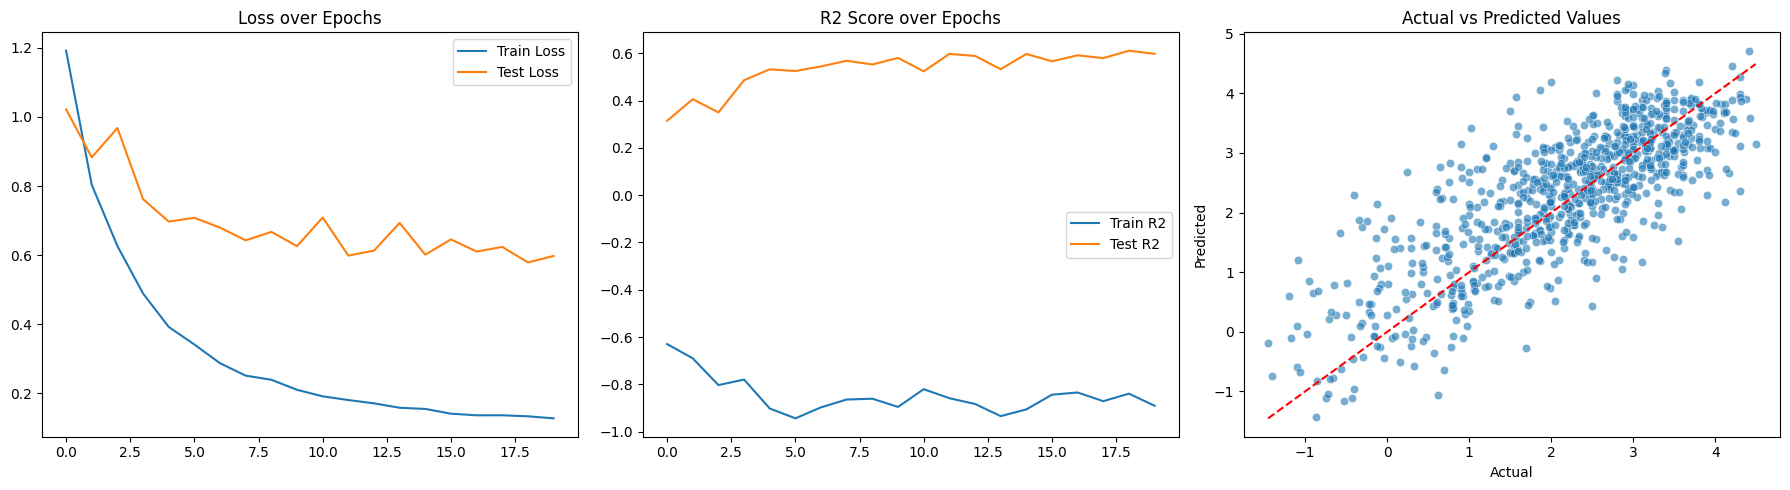

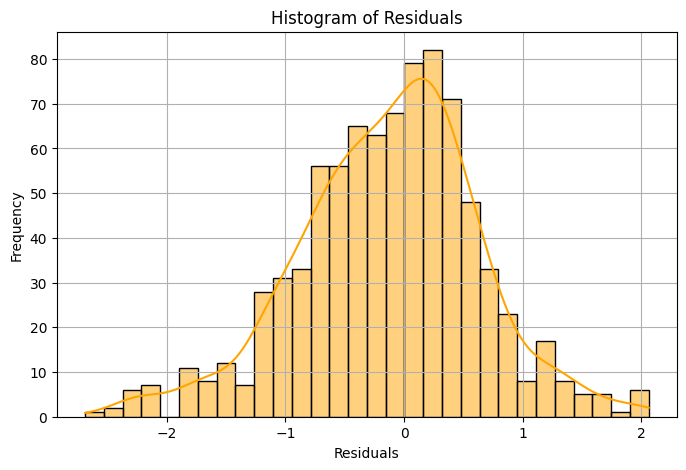

📊 Residual Standard Error (RSE) on all data: nan


<ipython-input-3-306885b1591d>:181: RuntimeWarning: invalid value encountered in sqrt
  rse = np.sqrt(np.sum(residuals**2) / (n - p))


In [ ]:
# 1. Load the dataset
data = pd.read_csv("Lipophilicity(1).csv")  # 🔁 Put the path to your CSV file


# 2. Tokenizer and ChemBERTa model
tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
bert_model = AutoModel.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")

# 3. Custom Dataset
class SMILESDataset(Dataset):
    def __init__(self, smiles, targets, tokenizer, max_length=128):
        self.smiles = smiles
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, idx):
        smile = str(self.smiles[idx])
        target = self.targets[idx]
        encoding = self.tokenizer(smile, padding='max_length', truncation=True,
                                  max_length=self.max_length, return_tensors='pt')
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'target': torch.tensor(target, dtype=torch.float)
        }

# 4. Train / Test Split
train_texts, test_texts, train_targets, test_targets = train_test_split(
    data['smiles'], data['exp'],
    test_size=0.2, random_state=42
)

train_dataset = SMILESDataset(train_texts.tolist(), train_targets.tolist(), tokenizer)
test_dataset = SMILESDataset(test_texts.tolist(), test_targets.tolist(), tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# 5. ChemBERTa-based Regression Model
class RegressionModel(nn.Module):
    def __init__(self, bert_model):
        super(RegressionModel, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(0.3)
        self.out = nn.Linear(768, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output if hasattr(outputs, 'pooler_output') else outputs.last_hidden_state[:, 0]
        x = self.dropout(pooled_output)
        return self.out(x)

model = RegressionModel(bert_model)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# 6. Training
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
loss_fn = nn.MSELoss()

epochs = 20
train_losses, test_losses = [], []
train_r2s, test_r2s = [], []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['target'].to(device).view(-1)

        outputs = model(input_ids, attention_mask).view(-1)
        loss = loss_fn(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_losses.append(train_loss / len(train_loader))

    model.eval()
    test_loss = 0
    preds, true_vals = [], []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['target'].to(device).view(-1)

            outputs = model(input_ids, attention_mask).view(-1)
            loss = loss_fn(outputs, targets)

            test_loss += loss.item()
            preds.extend(outputs.cpu().numpy().reshape(-1))
            true_vals.extend(targets.cpu().numpy().reshape(-1))

    test_losses.append(test_loss / len(test_loader))
    train_r2 = r2_score(train_targets[:len(preds)], preds)
    test_r2 = r2_score(true_vals, preds)
    train_r2s.append(train_r2)
    test_r2s.append(test_r2)

    print(f"Epoch {epoch+1} | Train Loss: {train_losses[-1]:.4f} | Test Loss: {test_losses[-1]:.4f} | R2: {test_r2:.4f}")

# 7. Final Evaluation
mae = mean_absolute_error(true_vals, preds)
mse = mean_squared_error(true_vals, preds)
rmse = np.sqrt(mse)
r2 = r2_score(true_vals, preds)


# Define a threshold within which predictions are considered "accurate"
accuracy_threshold = 0.5  # or another value depending on your use case

# Convert lists to NumPy arrays
predss = np.array(preds)
true_valss = np.array(true_vals)

# Calculate regression accuracy
accuracy = np.mean(np.abs(predss - true_valss) < accuracy_threshold)

print("\n✅ Final results:")
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")
print(f"Accuracy   : {accuracy:.4f}")


# 8. Visualizations
plt.figure(figsize=(18,5))

# Loss
plt.subplot(1,3,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss over Epochs')
plt.legend()

# R2 Score
plt.subplot(1,3,2)
plt.plot(train_r2s, label='Train R2')
plt.plot(test_r2s, label='Test R2')
plt.title('R2 Score over Epochs')
plt.legend()

# Actual vs Predicted
plt.subplot(1,3,3)
sns.scatterplot(x=true_vals, y=preds, alpha=0.6)
plt.plot([min(true_vals), max(true_vals)], [min(true_vals), max(true_vals)], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values')

plt.tight_layout()
plt.show()

# 9. Residual Analysis
residuals = np.array(true_vals) - np.array(preds)

# Histogram of residuals
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=30, kde=True, color='orange')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Residual Standard Error (RSE)
n = len(true_vals)
p = sum(p.numel() for p in model.parameters() if p.requires_grad)
rse = np.sqrt(np.sum(residuals**2) / (n - p))

print(f"📊 Residual Standard Error (RSE) on all data: {rse:.4f}")


Epoch 1/20 | Train Loss: 1.5414 | Test Loss: 1.1535 | Test R²: 0.2291
Epoch 2/20 | Train Loss: 1.0712 | Test Loss: 0.9702 | Test R²: 0.3581
Epoch 3/20 | Train Loss: 0.9255 | Test Loss: 1.0580 | Test R²: 0.2919
Epoch 4/20 | Train Loss: 0.8234 | Test Loss: 0.8703 | Test R²: 0.4277
Epoch 5/20 | Train Loss: 0.7267 | Test Loss: 0.8316 | Test R²: 0.4540
Epoch 6/20 | Train Loss: 0.6695 | Test Loss: 0.8901 | Test R²: 0.4119
Epoch 7/20 | Train Loss: 0.5819 | Test Loss: 0.8914 | Test R²: 0.4120
Epoch 8/20 | Train Loss: 0.5458 | Test Loss: 0.8945 | Test R²: 0.4047
Epoch 9/20 | Train Loss: 0.5165 | Test Loss: 0.8728 | Test R²: 0.4210
Epoch 10/20 | Train Loss: 0.4722 | Test Loss: 0.8872 | Test R²: 0.4133
Epoch 11/20 | Train Loss: 0.4159 | Test Loss: 0.7696 | Test R²: 0.4971
Epoch 12/20 | Train Loss: 0.4087 | Test Loss: 0.8056 | Test R²: 0.4730
Epoch 13/20 | Train Loss: 0.3741 | Test Loss: 0.7982 | Test R²: 0.4799
Epoch 14/20 | Train Loss: 0.3464 | Test Loss: 0.8027 | Test R²: 0.4752
Epoch 15/20 | T

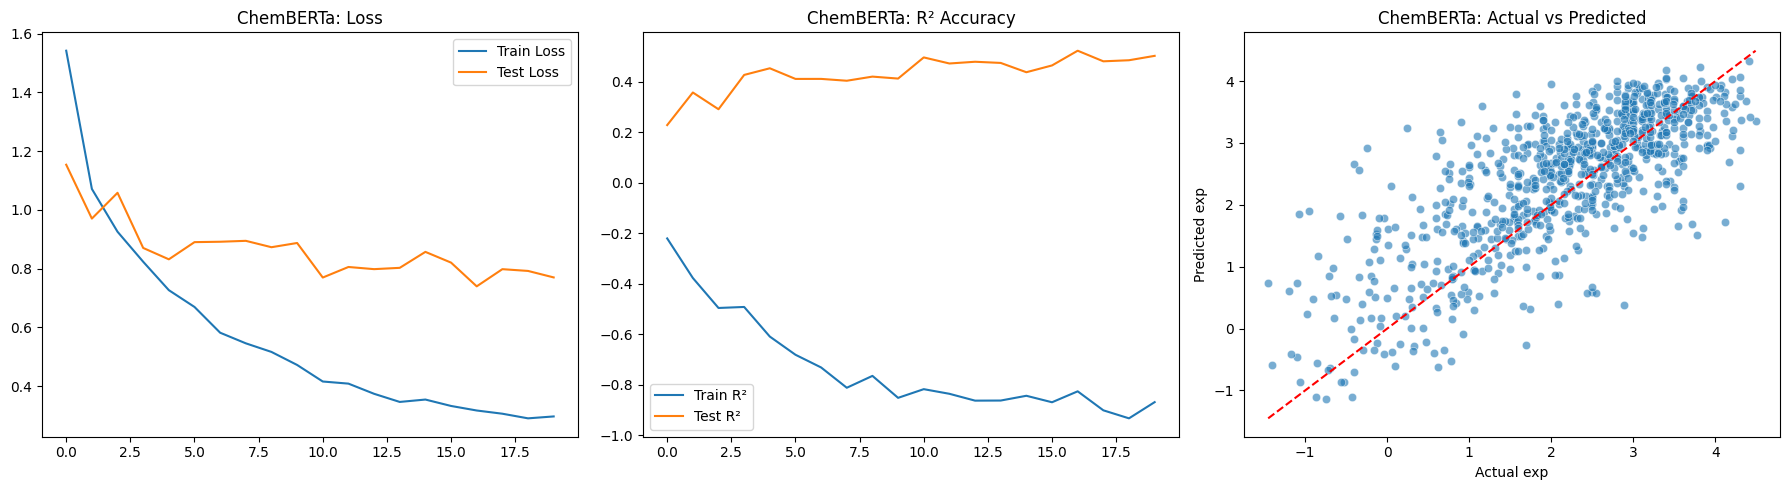

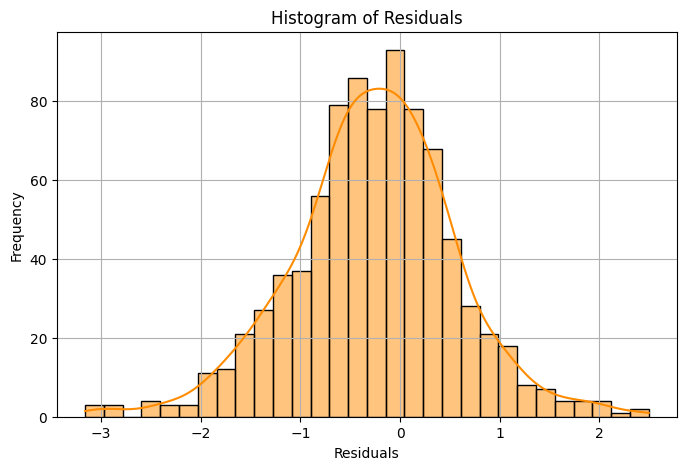

📊 Residual Standard Error (RSE): nan


<ipython-input-7-501d5cc4ad57>:187: RuntimeWarning: invalid value encountered in sqrt
  rse = np.sqrt(np.sum(residuals**2) / (n - p))


In [ ]:
data = pd.read_csv("Lipophilicity(4).csv")  # <<< put your path here


# 2. ChemBERTa tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
bert_model = AutoModel.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")

# 3. Custom Dataset
class SMILESDataset(Dataset):
    def __init__(self, smiles, targets, tokenizer, max_length=128):
        self.smiles = smiles
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, idx):
        smile = str(self.smiles[idx])
        target = self.targets[idx]
        encoding = self.tokenizer(smile, padding='max_length', truncation=True,
                                  max_length=self.max_length, return_tensors='pt')
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'target': torch.tensor(target, dtype=torch.float)
        }

# 4. Train / Test Split
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_targets, test_targets = train_test_split(
    data['smiles'],
    data['exp'],
    test_size=0.2,
    random_state=42
)

train_dataset = SMILESDataset(train_texts.tolist(), train_targets.tolist(), tokenizer)
test_dataset = SMILESDataset(test_texts.tolist(), test_targets.tolist(), tokenizer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# 5. Regression Model based on ChemBERTa
class RegressionModel(nn.Module):
    def __init__(self, bert_model):
        super(RegressionModel, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(0.5)
        self.out = nn.Linear(768, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output if hasattr(outputs, 'pooler_output') else outputs.last_hidden_state[:, 0]
        x = self.dropout(pooled_output)
        return self.out(x)

model = RegressionModel(bert_model)

# Fine-tune entire BERT
for param in model.bert.parameters():
    param.requires_grad = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# 6. Optimizer and Scheduler
optimizer = AdamW(model.parameters(), lr=1e-5)
num_training_steps = len(train_loader) * 30

scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

loss_fn = nn.MSELoss()

# 7. Training
epochs = 20
train_losses, test_losses = [], []
train_r2s, test_r2s = [], []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['target'].to(device).view(-1)

        outputs = model(input_ids, attention_mask).view(-1)
        loss = loss_fn(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()

    train_losses.append(train_loss / len(train_loader))

    model.eval()
    test_loss = 0
    preds, true_vals = [], []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['target'].to(device).view(-1)

            outputs = model(input_ids, attention_mask).view(-1)
            loss = loss_fn(outputs, targets)

            test_loss += loss.item()
            preds.extend(outputs.cpu().numpy().reshape(-1))
            true_vals.extend(targets.cpu().numpy().reshape(-1))

    test_losses.append(test_loss / len(test_loader))
    train_r2 = r2_score(train_targets[:len(preds)], preds)
    test_r2 = r2_score(true_vals, preds)
    train_r2s.append(train_r2)
    test_r2s.append(test_r2)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_losses[-1]:.4f} | Test Loss: {test_losses[-1]:.4f} | Test R²: {test_r2:.4f}")

# 8. Final Evaluation
mae = mean_absolute_error(true_vals, preds)
mse = mean_squared_error(true_vals, preds)
rmse = np.sqrt(mse)
r2 = r2_score(true_vals, preds)

print("\n✅ Final Results:")
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")

# 9. Visualizations
plt.figure(figsize=(18,5))

# Loss
plt.subplot(1,3,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('ChemBERTa: Loss')
plt.legend()

# R2 Score
plt.subplot(1,3,2)
plt.plot(train_r2s, label='Train R²')
plt.plot(test_r2s, label='Test R²')
plt.title('ChemBERTa: R² Accuracy')
plt.legend()

# Actual vs Predicted
plt.subplot(1,3,3)
sns.scatterplot(x=true_vals, y=preds, alpha=0.6)
plt.plot([min(true_vals), max(true_vals)], [min(true_vals), max(true_vals)], 'r--')
plt.xlabel('Actual exp')
plt.ylabel('Predicted exp')
plt.title('ChemBERTa: Actual vs Predicted')

plt.tight_layout()
plt.show()

# 10. Residual Analysis
residuals = np.array(true_vals) - np.array(preds)

# Histogram of residuals
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=30, kde=True, color='darkorange')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Residual Standard Error (RSE)
n = len(true_vals)
p = sum(p.numel() for p in model.parameters() if p.requires_grad)
rse = np.sqrt(np.sum(residuals**2) / (n - p))

print(f"📊 Residual Standard Error (RSE): {rse:.4f}")

# Case of the delaney_processed dataset

In [ ]:
chemin_3 = "delaney-processed(3).csv"
df_3 = pd.read_csv(chemin_3)


display(df_3.head(10))

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1
5,benzothiazole,-2.733,2,135.191,0,2,0,12.89,-1.50,c2ccc1scnc1c2
6,"2,2,4,6,6'-PCB",-6.545,1,326.437,0,2,1,0.00,-7.32,Clc1cc(Cl)c(c(Cl)c1)c2c(Cl)cccc2Cl
7,Estradiol,-4.138,1,272.388,2,4,0,40.46,-5.03,CC12CCC3C(CCc4cc(O)ccc34)C2CCC1O
8,Dieldrin,-4.533,1,380.913,0,5,0,12.53,-6.29,ClC4=C(Cl)C5(Cl)C3C1CC(C2OC12)C3C4(Cl)C5(Cl)Cl
9,Rotenone,-5.246,1,394.423,0,5,3,63.22,-4.42,COc5cc4OCC3Oc2c1CC(Oc1ccc2C(=O)C3c4cc5OC)C(C)=C


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/166 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/501 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/9.43k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/3.21k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/179M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/179M [00:00<?, ?B/s]

Epoch 1 | Train Loss: 3.9304 | Test Loss: 1.7873 | R2: 0.6003
Epoch 2 | Train Loss: 1.6675 | Test Loss: 1.3144 | R2: 0.7063
Epoch 3 | Train Loss: 1.1754 | Test Loss: 1.0145 | R2: 0.7732
Epoch 4 | Train Loss: 0.8345 | Test Loss: 0.8127 | R2: 0.8177
Epoch 5 | Train Loss: 0.6916 | Test Loss: 0.7610 | R2: 0.8342
Epoch 6 | Train Loss: 0.5501 | Test Loss: 0.6452 | R2: 0.8567
Epoch 7 | Train Loss: 0.4281 | Test Loss: 0.8016 | R2: 0.8253
Epoch 8 | Train Loss: 0.4152 | Test Loss: 0.7856 | R2: 0.8291
Epoch 9 | Train Loss: 0.3720 | Test Loss: 0.6633 | R2: 0.8565
Epoch 10 | Train Loss: 0.3427 | Test Loss: 0.6707 | R2: 0.8525
Epoch 11 | Train Loss: 0.3195 | Test Loss: 0.7490 | R2: 0.8371
Epoch 12 | Train Loss: 0.2542 | Test Loss: 0.5907 | R2: 0.8689
Epoch 13 | Train Loss: 0.2296 | Test Loss: 0.6307 | R2: 0.8606
Epoch 14 | Train Loss: 0.2460 | Test Loss: 0.6315 | R2: 0.8607
Epoch 15 | Train Loss: 0.2508 | Test Loss: 0.6180 | R2: 0.8625
Epoch 16 | Train Loss: 0.2252 | Test Loss: 0.7326 | R2: 0.8416
E

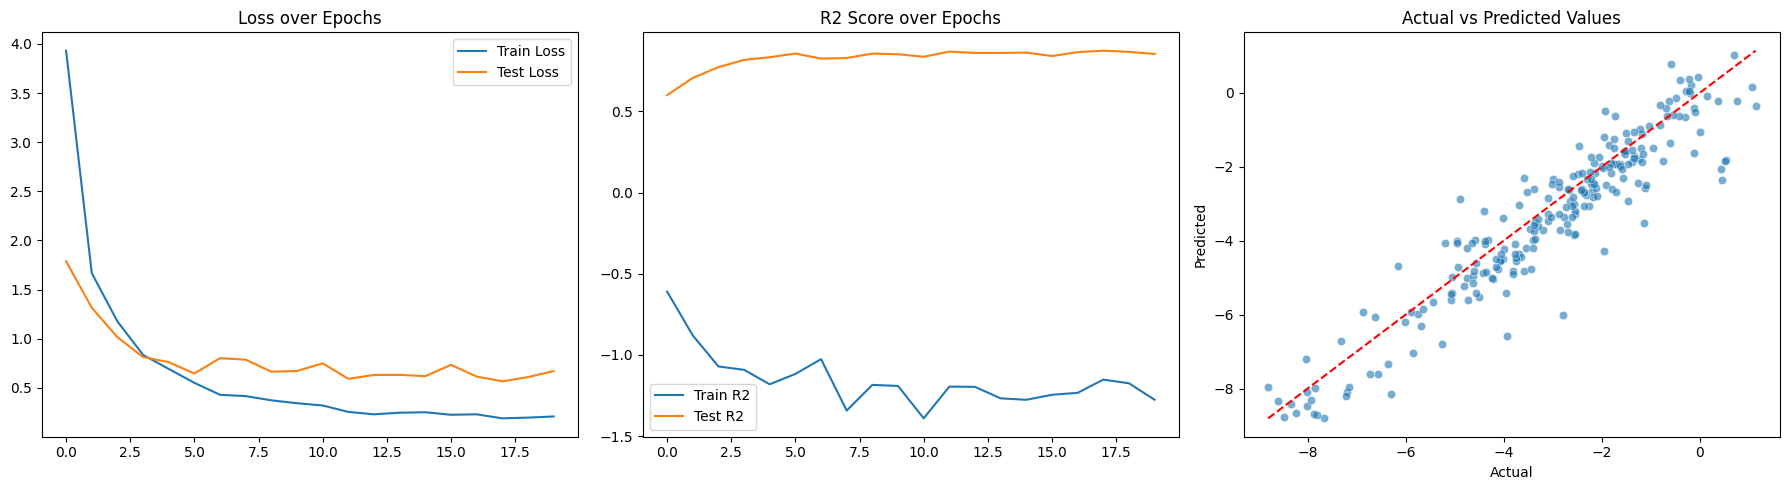

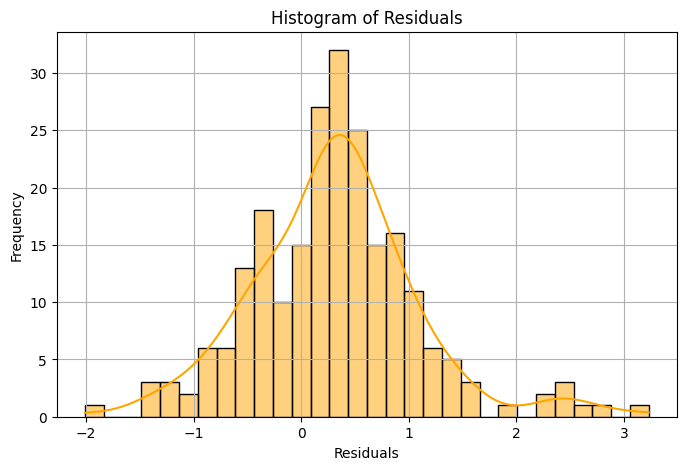

📊 Residual Standard Error (RSE) on all data: nan


<ipython-input-3-62878190f005>:180: RuntimeWarning: invalid value encountered in sqrt
  rse = np.sqrt(np.sum(residuals**2) / (n - p))


In [ ]:
# 1. Load the dataset
data = pd.read_csv("delaney-processed(2).csv")  # 🔁 Put the path to your CSV file


# 2. Tokenizer and ChemBERTa model
tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
bert_model = AutoModel.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")

# 3. Custom Dataset
class SMILESDataset(Dataset):
    def __init__(self, smiles, targets, tokenizer, max_length=128):
        self.smiles = smiles
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, idx):
        smile = str(self.smiles[idx])
        target = self.targets[idx]
        encoding = self.tokenizer(smile, padding='max_length', truncation=True,
                                  max_length=self.max_length, return_tensors='pt')
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'target': torch.tensor(target, dtype=torch.float)
        }

# 4. Train / Test Split
train_texts, test_texts, train_targets, test_targets = train_test_split(
    data['smiles'], data['measured log solubility in mols per litre'],
    test_size=0.2, random_state=42
)

train_dataset = SMILESDataset(train_texts.tolist(), train_targets.tolist(), tokenizer)
test_dataset = SMILESDataset(test_texts.tolist(), test_targets.tolist(), tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# 5. ChemBERTa-based Regression Model
class RegressionModel(nn.Module):
    def __init__(self, bert_model):
        super(RegressionModel, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(0.3)
        self.out = nn.Linear(768, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output if hasattr(outputs, 'pooler_output') else outputs.last_hidden_state[:, 0]
        x = self.dropout(pooled_output)
        return self.out(x)

model = RegressionModel(bert_model)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# 6. Training
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
loss_fn = nn.MSELoss()

epochs = 20
train_losses, test_losses = [], []
train_r2s, test_r2s = [], []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['target'].to(device).view(-1)

        outputs = model(input_ids, attention_mask).view(-1)
        loss = loss_fn(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_losses.append(train_loss / len(train_loader))

    model.eval()
    test_loss = 0
    preds, true_vals = [], []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['target'].to(device).view(-1)

            outputs = model(input_ids, attention_mask).view(-1)
            loss = loss_fn(outputs, targets)

            test_loss += loss.item()
            preds.extend(outputs.cpu().numpy().reshape(-1))
            true_vals.extend(targets.cpu().numpy().reshape(-1))

    test_losses.append(test_loss / len(test_loader))
    train_r2 = r2_score(train_targets[:len(preds)], preds)
    test_r2 = r2_score(true_vals, preds)
    train_r2s.append(train_r2)
    test_r2s.append(test_r2)

    print(f"Epoch {epoch+1} | Train Loss: {train_losses[-1]:.4f} | Test Loss: {test_losses[-1]:.4f} | R2: {test_r2:.4f}")

# 7. Final Evaluation
mae = mean_absolute_error(true_vals, preds)
mse = mean_squared_error(true_vals, preds)
rmse = np.sqrt(mse)
r2 = r2_score(true_vals, preds)


# Define a threshold within which predictions are considered "accurate"
accuracy_threshold = 0.5  # or another value depending on your use case

# Convert lists to NumPy arrays
predss = np.array(preds)
true_valss = np.array(true_vals)

# Calculate regression accuracy
accuracy = np.mean(np.abs(predss - true_valss) < accuracy_threshold)

print("\n✅ Final results:")
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")
print(f"Accuracy   : {accuracy:.4f}")

# 8. Visualizations
plt.figure(figsize=(18,5))

# Loss
plt.subplot(1,3,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss over Epochs')
plt.legend()

# R2 Score
plt.subplot(1,3,2)
plt.plot(train_r2s, label='Train R2')
plt.plot(test_r2s, label='Test R2')
plt.title('R2 Score over Epochs')
plt.legend()

# Actual vs Predicted
plt.subplot(1,3,3)
sns.scatterplot(x=true_vals, y=preds, alpha=0.6)
plt.plot([min(true_vals), max(true_vals)], [min(true_vals), max(true_vals)], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values')

plt.tight_layout()
plt.show()

# 9. Residual Analysis
residuals = np.array(true_vals) - np.array(preds)

# Histogram of residuals
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=30, kde=True, color='orange')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Residual Standard Error (RSE)
n = len(true_vals)
p = sum(p.numel() for p in model.parameters() if p.requires_grad)
rse = np.sqrt(np.sum(residuals**2) / (n - p))

print(f"📊 Residual Standard Error (RSE) on all data: {rse:.4f}")


Epoch 1/20 | Train Loss: 6.4364 | Test Loss: 3.6749 | Test R²: 0.1353
Epoch 2/20 | Train Loss: 2.8946 | Test Loss: 2.2253 | Test R²: 0.4717
Epoch 3/20 | Train Loss: 2.2647 | Test Loss: 1.7203 | Test R²: 0.5886
Epoch 4/20 | Train Loss: 1.8120 | Test Loss: 1.4568 | Test R²: 0.6526
Epoch 5/20 | Train Loss: 1.5328 | Test Loss: 1.3694 | Test R²: 0.6820
Epoch 6/20 | Train Loss: 1.3607 | Test Loss: 1.2717 | Test R²: 0.7078
Epoch 7/20 | Train Loss: 1.1945 | Test Loss: 1.2430 | Test R²: 0.7200
Epoch 8/20 | Train Loss: 1.2081 | Test Loss: 1.2189 | Test R²: 0.7287
Epoch 9/20 | Train Loss: 1.0342 | Test Loss: 1.0319 | Test R²: 0.7702
Epoch 10/20 | Train Loss: 0.9361 | Test Loss: 1.1194 | Test R²: 0.7506
Epoch 11/20 | Train Loss: 0.8536 | Test Loss: 0.9115 | Test R²: 0.7953
Epoch 12/20 | Train Loss: 0.8391 | Test Loss: 0.8932 | Test R²: 0.8001
Epoch 13/20 | Train Loss: 0.7298 | Test Loss: 0.9400 | Test R²: 0.7942
Epoch 14/20 | Train Loss: 0.6992 | Test Loss: 0.9408 | Test R²: 0.7893
Epoch 15/20 | T

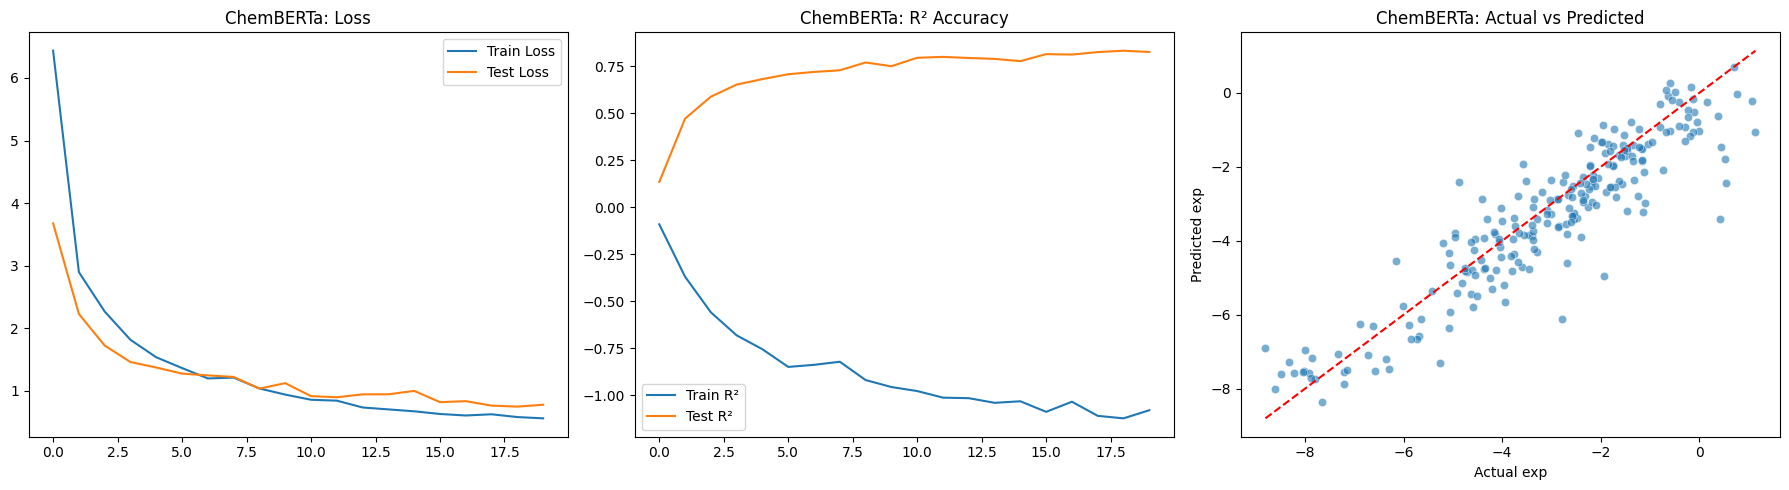

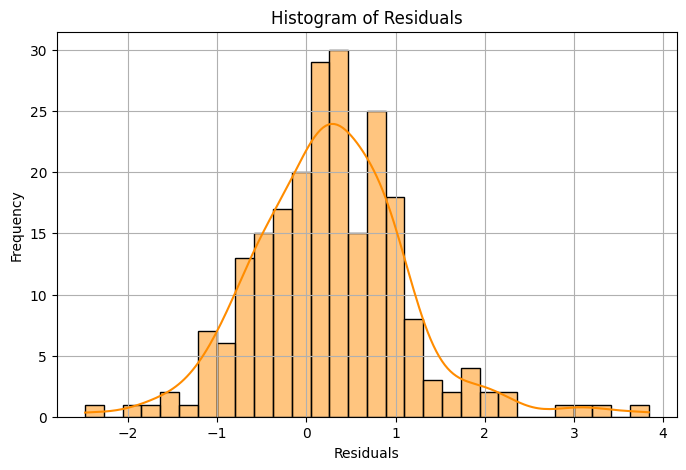

📊 Residual Standard Error (RSE): nan


<ipython-input-10-c8bf317078cc>:188: RuntimeWarning: invalid value encountered in sqrt
  rse = np.sqrt(np.sum(residuals**2) / (n - p))


In [ ]:
data = pd.read_csv("delaney-processed(1).csv")  # <<< put your path here


# 2. ChemBERTa tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
bert_model = AutoModel.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")

# 3. Custom Dataset
class SMILESDataset(Dataset):
    def __init__(self, smiles, targets, tokenizer, max_length=128):
        self.smiles = smiles
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, idx):
        smile = str(self.smiles[idx])
        target = self.targets[idx]
        encoding = self.tokenizer(smile, padding='max_length', truncation=True,
                                  max_length=self.max_length, return_tensors='pt')
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'target': torch.tensor(target, dtype=torch.float)
        }

# 4. Train / Test Split
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_targets, test_targets = train_test_split(
    data['smiles'],
    data['measured log solubility in mols per litre'],
    test_size=0.2,
    random_state=42
)


train_dataset = SMILESDataset(train_texts.tolist(), train_targets.tolist(), tokenizer)
test_dataset = SMILESDataset(test_texts.tolist(), test_targets.tolist(), tokenizer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# 5. Regression Model based on ChemBERTa
class RegressionModel(nn.Module):
    def __init__(self, bert_model):
        super(RegressionModel, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(0.5)
        self.out = nn.Linear(768, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output if hasattr(outputs, 'pooler_output') else outputs.last_hidden_state[:, 0]
        x = self.dropout(pooled_output)
        return self.out(x)

model = RegressionModel(bert_model)

# Fine-tune entire BERT
for param in model.bert.parameters():
    param.requires_grad = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# 6. Optimizer and Scheduler
optimizer = AdamW(model.parameters(), lr=1e-5)
num_training_steps = len(train_loader) * 30

scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

loss_fn = nn.MSELoss()

# 7. Training
epochs = 20
train_losses, test_losses = [], []
train_r2s, test_r2s = [], []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['target'].to(device).view(-1)

        outputs = model(input_ids, attention_mask).view(-1)
        loss = loss_fn(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()

    train_losses.append(train_loss / len(train_loader))

    model.eval()
    test_loss = 0
    preds, true_vals = [], []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['target'].to(device).view(-1)

            outputs = model(input_ids, attention_mask).view(-1)
            loss = loss_fn(outputs, targets)

            test_loss += loss.item()
            preds.extend(outputs.cpu().numpy().reshape(-1))
            true_vals.extend(targets.cpu().numpy().reshape(-1))

    test_losses.append(test_loss / len(test_loader))
    train_r2 = r2_score(train_targets[:len(preds)], preds)
    test_r2 = r2_score(true_vals, preds)
    train_r2s.append(train_r2)
    test_r2s.append(test_r2)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_losses[-1]:.4f} | Test Loss: {test_losses[-1]:.4f} | Test R²: {test_r2:.4f}")

# 8. Final Evaluation
mae = mean_absolute_error(true_vals, preds)
mse = mean_squared_error(true_vals, preds)
rmse = np.sqrt(mse)
r2 = r2_score(true_vals, preds)

print("\n✅ Final Results:")
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")

# 9. Visualizations
plt.figure(figsize=(18,5))

# Loss
plt.subplot(1,3,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('ChemBERTa: Loss')
plt.legend()

# R2 Score
plt.subplot(1,3,2)
plt.plot(train_r2s, label='Train R²')
plt.plot(test_r2s, label='Test R²')
plt.title('ChemBERTa: R² Accuracy')
plt.legend()

# Actual vs Predicted
plt.subplot(1,3,3)
sns.scatterplot(x=true_vals, y=preds, alpha=0.6)
plt.plot([min(true_vals), max(true_vals)], [min(true_vals), max(true_vals)], 'r--')
plt.xlabel('Actual exp')
plt.ylabel('Predicted exp')
plt.title('ChemBERTa: Actual vs Predicted')

plt.tight_layout()
plt.show()

# 10. Residual Analysis
residuals = np.array(true_vals) - np.array(preds)

# Histogram of residuals
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=30, kde=True, color='darkorange')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Residual Standard Error (RSE)
n = len(true_vals)
p = sum(p.numel() for p in model.parameters() if p.requires_grad)
rse = np.sqrt(np.sum(residuals**2) / (n - p))

print(f"📊 Residual Standard Error (RSE): {rse:.4f}")

# Case of the bace dataset

In [ ]:
chemin_4 = "bace(2).csv"
df_4 = pd.read_csv(chemin_4)


display(df_4.head(10))

,mol,CID,Class,Model,pIC50,MW,AlogP,HBA,HBD,RB,...,PEOE6 (PEOE6),PEOE7 (PEOE7),PEOE8 (PEOE8),PEOE9 (PEOE9),PEOE10 (PEOE10),PEOE11 (PEOE11),PEOE12 (PEOE12),PEOE13 (PEOE13),PEOE14 (PEOE14),canvasUID
0,O1CC[C@@H](NC(=O)[C@@H](Cc2cc3cc(ccc3nc2N)-c2c...,BACE_1,1,Train,9.154901,431.56979,4.4014,3,2,5,...,53.205711,78.640335,226.85541,107.43491,37.133846,0.000000,7.980170,0.000000,0.000000,1
1,Fc1cc(cc(F)c1)C[C@H](NC(=O)[C@@H](N1CC[C@](NC(...,BACE_2,1,Train,8.853872,657.81073,2.6412,5,4,16,...,73.817162,47.171600,365.67694,174.07675,34.923889,7.980170,24.148668,0.000000,24.663788,2
2,S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H](...,BACE_3,1,Train,8.698970,591.74091,2.5499,4,3,11,...,70.365707,47.941147,192.40652,255.75255,23.654478,0.230159,15.879790,0.000000,24.663788,3
3,S1(=O)(=O)C[C@@H](Cc2cc(O[C@H](COCC)C(F)(F)F)c...,BACE_4,1,Train,8.698970,591.67828,3.1680,4,3,12,...,56.657166,37.954151,194.35304,202.76335,36.498634,0.980913,8.188327,0.000000,26.385181,4
4,S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H](...,BACE_5,1,Train,8.698970,629.71283,3.5086,3,3,11,...,78.945702,39.361153,179.71288,220.46130,23.654478,0.230159,15.879790,0.000000,26.100143,5
5,S1(=O)C[C@@H](Cc2cc(OC(C(F)(F)F)C(F)(F)F)c(N)c...,BACE_6,1,Train,8.698970,585.59772,3.8615,2,3,10,...,56.657166,35.376312,179.54280,132.09418,33.514153,0.000000,8.188327,0.980913,28.106575,6
6,S(=O)(=O)(CCCCC)C[C@@H](NC(=O)c1cccnc1)C(=O)N[...,BACE_7,1,Train,8.698970,645.78009,3.1973,5,4,18,...,63.830162,52.390511,263.78134,190.54213,45.370659,0.000000,23.859961,0.000000,24.663788,7
7,Fc1c2c(ccc1)[C@@]([NH+]=C2N)(C=1C=C(C)C(=O)N(C...,BACE_8,1,Train,8.612610,477.55200,3.7096,2,0,4,...,42.899986,65.744499,171.12137,146.12990,28.109447,0.000000,-6.106466,13.955495,12.331894,8
8,O1c2c(cc(cc2)CC)[C@@H]([NH2+]C[C@@H](O)[C@H]2N...,BACE_9,1,Train,8.602060,556.71503,4.7010,4,3,5,...,53.205711,68.418541,299.00003,140.68362,28.755558,0.000000,15.879790,6.904104,24.663788,9
9,O=C1N(CCCC1)C(C)(C)[C@@H]1C[C@@H](CCC1)C(=O)N[...,BACE_10,1,Train,8.602060,562.80573,4.3981,3,3,12,...,93.700790,57.796051,379.48660,151.64662,23.654478,0.000000,24.148668,0.000000,24.663788,10


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/166 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/501 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/9.43k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/3.21k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/179M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/179M [00:00<?, ?B/s]

Epoch 1 | Train Loss: 5.5965 | Test Loss: 1.1109 | R2: 0.3538
Epoch 2 | Train Loss: 1.1264 | Test Loss: 0.9409 | R2: 0.4530
Epoch 3 | Train Loss: 0.8182 | Test Loss: 0.7283 | R2: 0.5764
Epoch 4 | Train Loss: 0.7247 | Test Loss: 0.7472 | R2: 0.5657
Epoch 5 | Train Loss: 0.6165 | Test Loss: 0.5572 | R2: 0.6751
Epoch 6 | Train Loss: 0.5347 | Test Loss: 0.5955 | R2: 0.6532
Epoch 7 | Train Loss: 0.4909 | Test Loss: 0.7162 | R2: 0.5833
Epoch 8 | Train Loss: 0.4485 | Test Loss: 0.7020 | R2: 0.5916
Epoch 9 | Train Loss: 0.4355 | Test Loss: 0.6035 | R2: 0.6489
Epoch 10 | Train Loss: 0.3692 | Test Loss: 0.5762 | R2: 0.6645
Epoch 11 | Train Loss: 0.3461 | Test Loss: 0.5529 | R2: 0.6781
Epoch 12 | Train Loss: 0.3211 | Test Loss: 0.5250 | R2: 0.6945
Epoch 13 | Train Loss: 0.2769 | Test Loss: 0.6211 | R2: 0.6386
Epoch 14 | Train Loss: 0.2932 | Test Loss: 0.5598 | R2: 0.6739
Epoch 15 | Train Loss: 0.2791 | Test Loss: 0.6865 | R2: 0.6011
Epoch 16 | Train Loss: 0.2704 | Test Loss: 0.5602 | R2: 0.6739
E

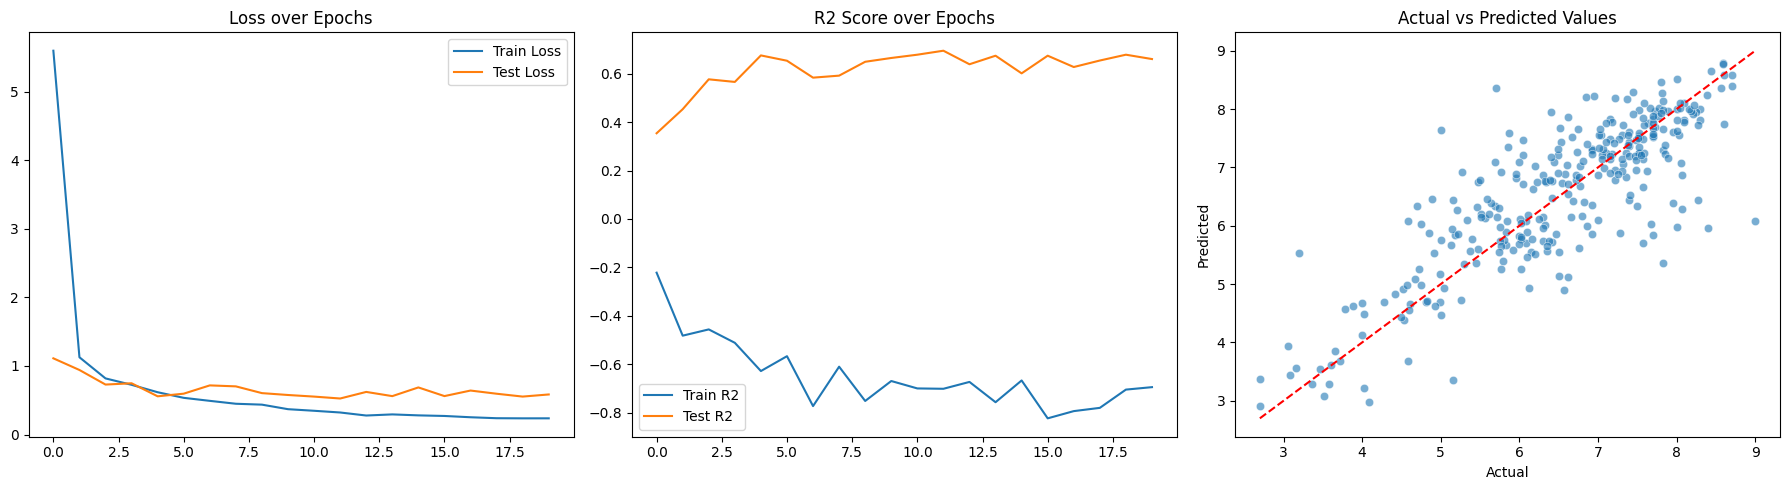

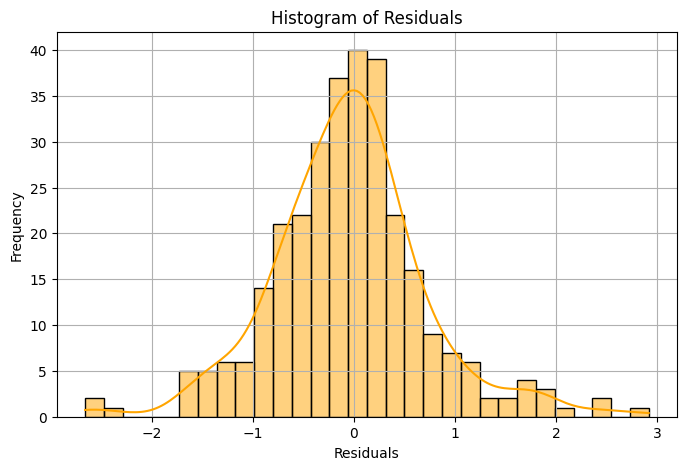

📊 Residual Standard Error (RSE) on all data: nan


<ipython-input-4-d4c5180204cf>:179: RuntimeWarning: invalid value encountered in sqrt
  rse = np.sqrt(np.sum(residuals**2) / (n - p))


In [ ]:
# 1. Load the dataset
data = pd.read_csv("bace(1).csv")  # 🔁 Put the path to your CSV file

# 2. Tokenizer and ChemBERTa model
tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
bert_model = AutoModel.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")

# 3. Custom Dataset
class SMILESDataset(Dataset):
    def __init__(self, smiles, targets, tokenizer, max_length=128):
        self.smiles = smiles
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, idx):
        smile = str(self.smiles[idx])
        target = self.targets[idx]
        encoding = self.tokenizer(smile, padding='max_length', truncation=True,
                                  max_length=self.max_length, return_tensors='pt')
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'target': torch.tensor(target, dtype=torch.float)
        }

# 4. Train / Test Split
train_texts, test_texts, train_targets, test_targets = train_test_split(
    data['mol'], data['pIC50'],
    test_size=0.2, random_state=42
)

train_dataset = SMILESDataset(train_texts.tolist(), train_targets.tolist(), tokenizer)
test_dataset = SMILESDataset(test_texts.tolist(), test_targets.tolist(), tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# 5. ChemBERTa-based Regression Model
class RegressionModel(nn.Module):
    def __init__(self, bert_model):
        super(RegressionModel, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(0.3)
        self.out = nn.Linear(768, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output if hasattr(outputs, 'pooler_output') else outputs.last_hidden_state[:, 0]
        x = self.dropout(pooled_output)
        return self.out(x)

model = RegressionModel(bert_model)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# 6. Training
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
loss_fn = nn.MSELoss()

epochs = 20
train_losses, test_losses = [], []
train_r2s, test_r2s = [], []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['target'].to(device).view(-1)

        outputs = model(input_ids, attention_mask).view(-1)
        loss = loss_fn(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_losses.append(train_loss / len(train_loader))

    model.eval()
    test_loss = 0
    preds, true_vals = [], []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['target'].to(device).view(-1)

            outputs = model(input_ids, attention_mask).view(-1)
            loss = loss_fn(outputs, targets)

            test_loss += loss.item()
            preds.extend(outputs.cpu().numpy().reshape(-1))
            true_vals.extend(targets.cpu().numpy().reshape(-1))

    test_losses.append(test_loss / len(test_loader))
    train_r2 = r2_score(train_targets[:len(preds)], preds)
    test_r2 = r2_score(true_vals, preds)
    train_r2s.append(train_r2)
    test_r2s.append(test_r2)

    print(f"Epoch {epoch+1} | Train Loss: {train_losses[-1]:.4f} | Test Loss: {test_losses[-1]:.4f} | R2: {test_r2:.4f}")

# 7. Final Evaluation
mae = mean_absolute_error(true_vals, preds)
mse = mean_squared_error(true_vals, preds)
rmse = np.sqrt(mse)
r2 = r2_score(true_vals, preds)

# Define a threshold within which predictions are considered "accurate"
accuracy_threshold = 0.5  # or another value depending on your use case

# Convert lists to NumPy arrays
predss = np.array(preds)
true_valss = np.array(true_vals)

# Calculate regression accuracy
accuracy = np.mean(np.abs(predss - true_valss) < accuracy_threshold)

print("\n✅ Final results:")
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")
print(f"Accuracy   : {accuracy:.4f}")


# 8. Visualizations
plt.figure(figsize=(18,5))

# Loss
plt.subplot(1,3,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss over Epochs')
plt.legend()

# R2 Score
plt.subplot(1,3,2)
plt.plot(train_r2s, label='Train R2')
plt.plot(test_r2s, label='Test R2')
plt.title('R2 Score over Epochs')
plt.legend()

# Actual vs Predicted
plt.subplot(1,3,3)
sns.scatterplot(x=true_vals, y=preds, alpha=0.6)
plt.plot([min(true_vals), max(true_vals)], [min(true_vals), max(true_vals)], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values')

plt.tight_layout()
plt.show()

# 9. Residual Analysis
residuals = np.array(true_vals) - np.array(preds)

# Histogram of residuals
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=30, kde=True, color='orange')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Residual Standard Error (RSE)
n = len(true_vals)
p = sum(p.numel() for p in model.parameters() if p.requires_grad)
rse = np.sqrt(np.sum(residuals**2) / (n - p))

print(f"📊 Residual Standard Error (RSE) on all data: {rse:.4f}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/166 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/501 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/9.43k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/3.21k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/179M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/179M [00:00<?, ?B/s]

Epoch 1/200 | Train Loss: 17.1647 | Test Loss: 2.6889 | Test R²: -0.5927
Epoch 2/200 | Train Loss: 2.1314 | Test Loss: 1.4786 | Test R²: 0.1709
Epoch 3/200 | Train Loss: 1.4423 | Test Loss: 1.1828 | Test R²: 0.3456
Epoch 4/200 | Train Loss: 1.2425 | Test Loss: 1.1486 | Test R²: 0.3657
Epoch 5/200 | Train Loss: 1.1291 | Test Loss: 1.0010 | Test R²: 0.4464
Epoch 6/200 | Train Loss: 1.0494 | Test Loss: 0.8697 | Test R²: 0.5174
Epoch 7/200 | Train Loss: 0.9243 | Test Loss: 0.7699 | Test R²: 0.5707
Epoch 8/200 | Train Loss: 0.8742 | Test Loss: 0.7775 | Test R²: 0.5673
Epoch 9/200 | Train Loss: 0.7991 | Test Loss: 0.7460 | Test R²: 0.5855
Epoch 10/200 | Train Loss: 0.7766 | Test Loss: 0.7008 | Test R²: 0.6091
Epoch 11/200 | Train Loss: 0.6821 | Test Loss: 0.7921 | Test R²: 0.5608
Epoch 12/200 | Train Loss: 0.6980 | Test Loss: 0.6744 | Test R²: 0.6231
Epoch 13/200 | Train Loss: 0.6103 | Test Loss: 0.7066 | Test R²: 0.6047
Epoch 14/200 | Train Loss: 0.6129 | Test Loss: 0.6844 | Test R²: 0.6177

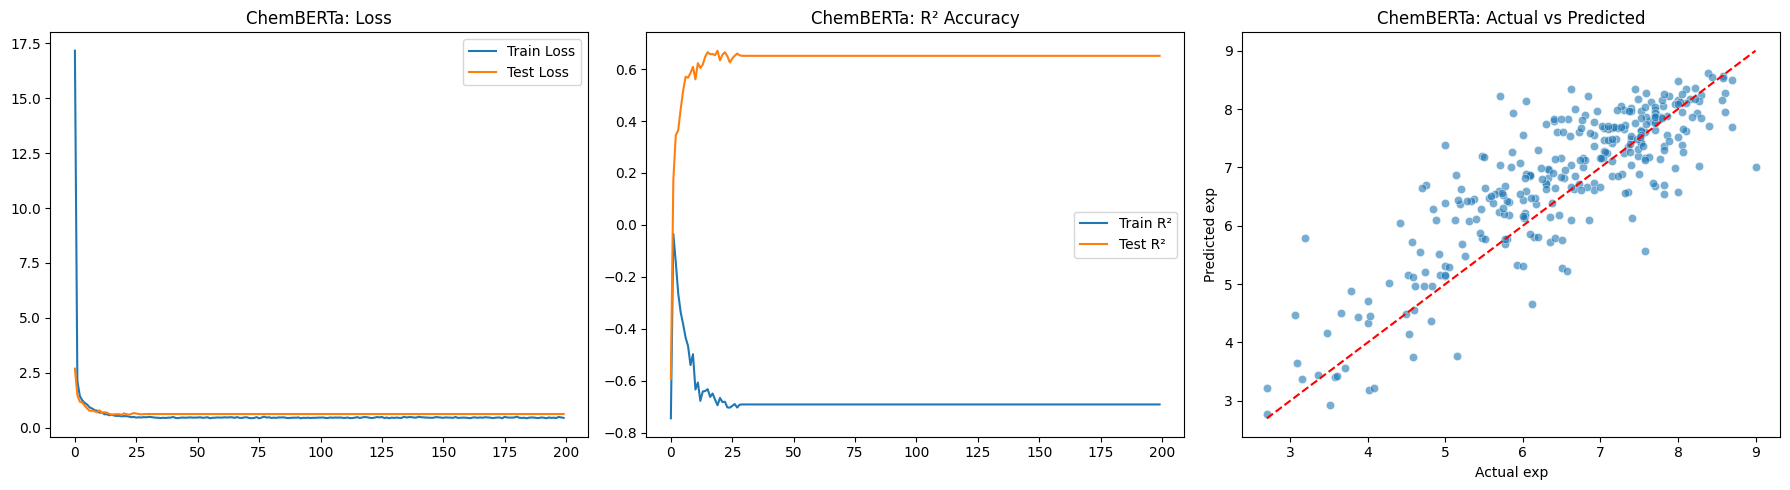

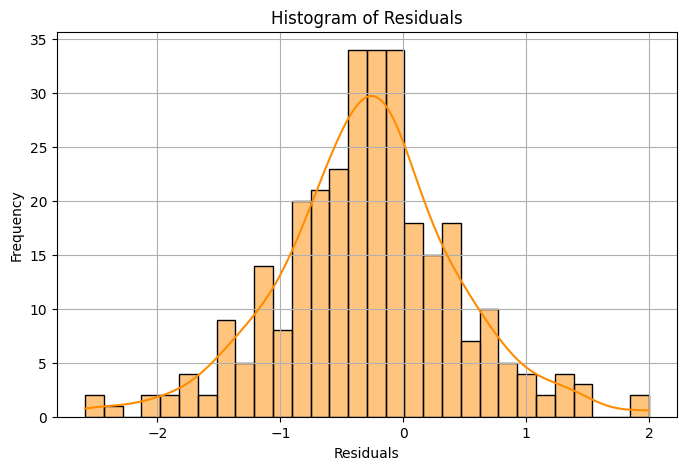

📊 Residual Standard Error (RSE): nan


<ipython-input-2-4a2a0bc84b47>:188: RuntimeWarning: invalid value encountered in sqrt
  rse = np.sqrt(np.sum(residuals**2) / (n - p))


In [ ]:
data = pd.read_csv("bace(1).csv")  # <<< put your path here


# 2. ChemBERTa tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
bert_model = AutoModel.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")

# 3. Custom Dataset
class SMILESDataset(Dataset):
    def __init__(self, smiles, targets, tokenizer, max_length=128):
        self.smiles = smiles
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, idx):
        smile = str(self.smiles[idx])
        target = self.targets[idx]
        encoding = self.tokenizer(smile, padding='max_length', truncation=True,
                                  max_length=self.max_length, return_tensors='pt')
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'target': torch.tensor(target, dtype=torch.float)
        }

# 4. Train / Test Split
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_targets, test_targets = train_test_split(
    data['mol'],
    data['pIC50'],
    test_size=0.2,
    random_state=42
)


train_dataset = SMILESDataset(train_texts.tolist(), train_targets.tolist(), tokenizer)
test_dataset = SMILESDataset(test_texts.tolist(), test_targets.tolist(), tokenizer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# 5. Regression Model based on ChemBERTa
class RegressionModel(nn.Module):
    def __init__(self, bert_model):
        super(RegressionModel, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(0.5)
        self.out = nn.Linear(768, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output if hasattr(outputs, 'pooler_output') else outputs.last_hidden_state[:, 0]
        x = self.dropout(pooled_output)
        return self.out(x)

model = RegressionModel(bert_model)

# Fine-tune entire BERT
for param in model.bert.parameters():
    param.requires_grad = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# 6. Optimizer and Scheduler
optimizer = AdamW(model.parameters(), lr=1e-5)
num_training_steps = len(train_loader) * 30

scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

loss_fn = nn.MSELoss()

# 7. Training
epochs = 200
train_losses, test_losses = [], []
train_r2s, test_r2s = [], []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['target'].to(device).view(-1)

        outputs = model(input_ids, attention_mask).view(-1)
        loss = loss_fn(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()

    train_losses.append(train_loss / len(train_loader))

    model.eval()
    test_loss = 0
    preds, true_vals = [], []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['target'].to(device).view(-1)

            outputs = model(input_ids, attention_mask).view(-1)
            loss = loss_fn(outputs, targets)

            test_loss += loss.item()
            preds.extend(outputs.cpu().numpy().reshape(-1))
            true_vals.extend(targets.cpu().numpy().reshape(-1))

    test_losses.append(test_loss / len(test_loader))
    train_r2 = r2_score(train_targets[:len(preds)], preds)
    test_r2 = r2_score(true_vals, preds)
    train_r2s.append(train_r2)
    test_r2s.append(test_r2)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_losses[-1]:.4f} | Test Loss: {test_losses[-1]:.4f} | Test R²: {test_r2:.4f}")

# 8. Final Evaluation
mae = mean_absolute_error(true_vals, preds)
mse = mean_squared_error(true_vals, preds)
rmse = np.sqrt(mse)
r2 = r2_score(true_vals, preds)

print("\n✅ Final Results:")
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")

# 9. Visualizations
plt.figure(figsize=(18,5))

# Loss
plt.subplot(1,3,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('ChemBERTa: Loss')
plt.legend()

# R2 Score
plt.subplot(1,3,2)
plt.plot(train_r2s, label='Train R²')
plt.plot(test_r2s, label='Test R²')
plt.title('ChemBERTa: R² Accuracy')
plt.legend()

# Actual vs Predicted
plt.subplot(1,3,3)
sns.scatterplot(x=true_vals, y=preds, alpha=0.6)
plt.plot([min(true_vals), max(true_vals)], [min(true_vals), max(true_vals)], 'r--')
plt.xlabel('Actual exp')
plt.ylabel('Predicted exp')
plt.title('ChemBERTa: Actual vs Predicted')

plt.tight_layout()
plt.show()

# 10. Residual Analysis
residuals = np.array(true_vals) - np.array(preds)

# Histogram of residuals
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=30, kde=True, color='darkorange')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Residual Standard Error (RSE)
n = len(true_vals)
p = sum(p.numel() for p in model.parameters() if p.requires_grad)
rse = np.sqrt(np.sum(residuals**2) / (n - p))

print(f"📊 Residual Standard Error (RSE): {rse:.4f}")

# Case of the logP_synthetic_dataset dataset

In [ ]:
chemin_5 = "logP_synthetic_dataset(1).csv"
df_5 = pd.read_csv(chemin_5)


display(df_5.head(10))

,slimp,exp
0,C(C=CBr)N,0.3
1,CCC(CO)Br,1.3
2,[13CH3][13CH2][13CH2][13CH2][13CH2][13CH2]O,2.0
3,CCCOCCP,0.6
4,C(C(F)(F)F)F,1.7
5,[2H]C([2H])C(C)(C)Cl,1.8
6,CCCC(CI)O,2.0
7,CCCCCC[CH+]C,3.9
8,C(CO)NCCO,-1.4
9,CCCCP(C)P,1.1


Epoch 1 | Train Loss: 0.5848 | Test Loss: 0.2796 | R2: 0.8307
Epoch 2 | Train Loss: 0.2394 | Test Loss: 0.1558 | R2: 0.9057
Epoch 3 | Train Loss: 0.1626 | Test Loss: 0.1719 | R2: 0.8961
Epoch 4 | Train Loss: 0.1360 | Test Loss: 0.1239 | R2: 0.9253
Epoch 5 | Train Loss: 0.1157 | Test Loss: 0.0940 | R2: 0.9431
Epoch 6 | Train Loss: 0.0946 | Test Loss: 0.0918 | R2: 0.9445
Epoch 7 | Train Loss: 0.0865 | Test Loss: 0.0814 | R2: 0.9508
Epoch 8 | Train Loss: 0.0754 | Test Loss: 0.0727 | R2: 0.9561
Epoch 9 | Train Loss: 0.0682 | Test Loss: 0.1016 | R2: 0.9386
Epoch 10 | Train Loss: 0.0621 | Test Loss: 0.0986 | R2: 0.9404
Epoch 11 | Train Loss: 0.0578 | Test Loss: 0.0879 | R2: 0.9468
Epoch 12 | Train Loss: 0.0515 | Test Loss: 0.0913 | R2: 0.9448
Epoch 13 | Train Loss: 0.0495 | Test Loss: 0.0743 | R2: 0.9550
Epoch 14 | Train Loss: 0.0443 | Test Loss: 0.0680 | R2: 0.9590
Epoch 15 | Train Loss: 0.0429 | Test Loss: 0.0749 | R2: 0.9547
Epoch 16 | Train Loss: 0.0395 | Test Loss: 0.0785 | R2: 0.9526
E

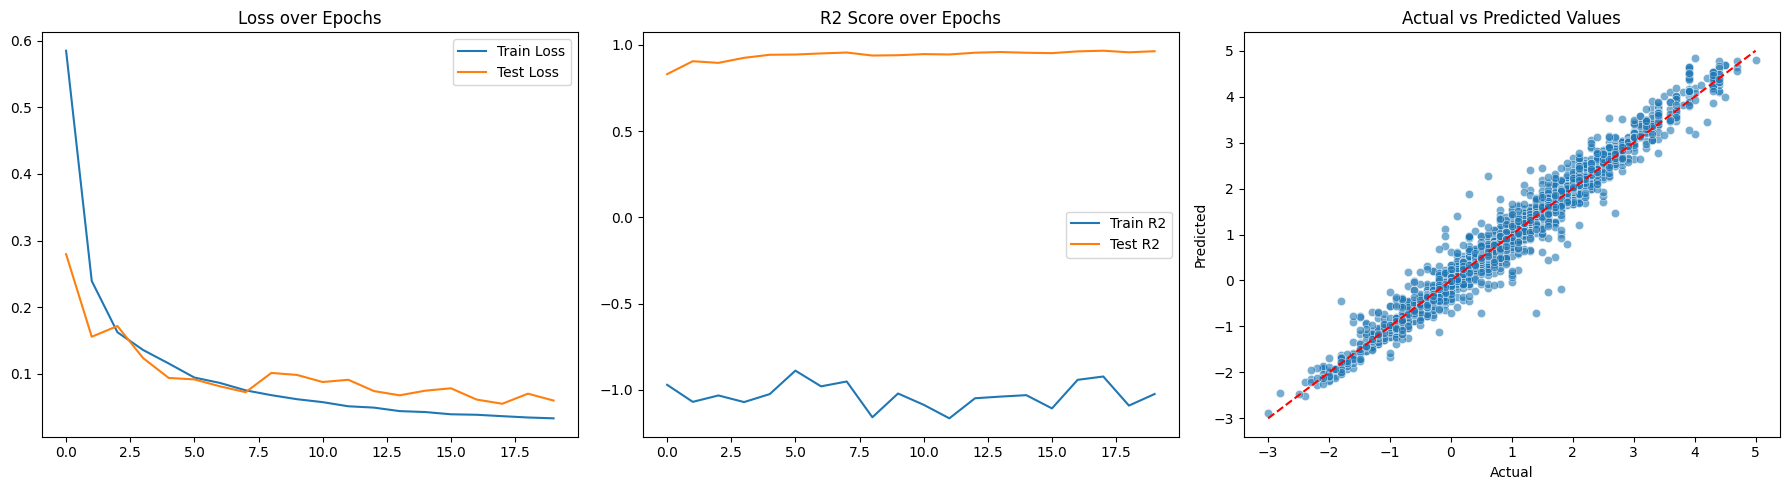

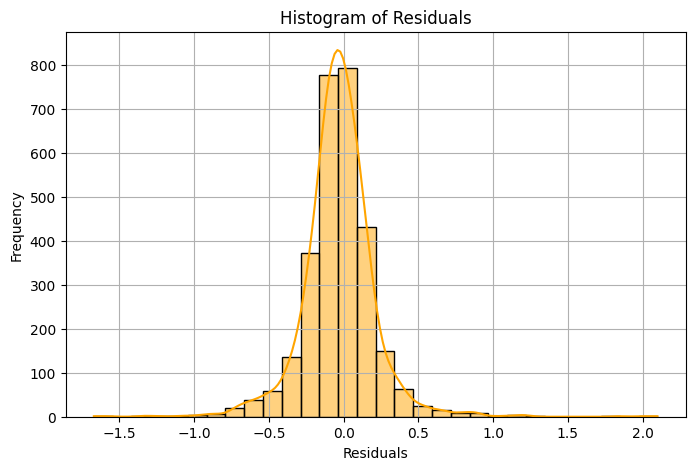

📊 Residual Standard Error (RSE) on all data: nan


<ipython-input-8-cfab08d767de>:180: RuntimeWarning: invalid value encountered in sqrt
  rse = np.sqrt(np.sum(residuals**2) / (n - p))


In [ ]:
# 1. Load the dataset
data = pd.read_csv("logP_synthetic_dataset(1).csv")  # 🔁 Put the path to your CSV file


# 2. Tokenizer and ChemBERTa model
tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
bert_model = AutoModel.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")

# 3. Custom Dataset
class SMILESDataset(Dataset):
    def __init__(self, smiles, targets, tokenizer, max_length=128):
        self.smiles = smiles
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, idx):
        smile = str(self.smiles[idx])
        target = self.targets[idx]
        encoding = self.tokenizer(smile, padding='max_length', truncation=True,
                                  max_length=self.max_length, return_tensors='pt')
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'target': torch.tensor(target, dtype=torch.float)
        }

# 4. Train / Test Split
train_texts, test_texts, train_targets, test_targets = train_test_split(
    data['slimp'], data['exp'],
    test_size=0.2, random_state=42
)

train_dataset = SMILESDataset(train_texts.tolist(), train_targets.tolist(), tokenizer)
test_dataset = SMILESDataset(test_texts.tolist(), test_targets.tolist(), tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# 5. ChemBERTa-based Regression Model
class RegressionModel(nn.Module):
    def __init__(self, bert_model):
        super(RegressionModel, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(0.3)
        self.out = nn.Linear(768, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output if hasattr(outputs, 'pooler_output') else outputs.last_hidden_state[:, 0]
        x = self.dropout(pooled_output)
        return self.out(x)

model = RegressionModel(bert_model)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# 6. Training
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
loss_fn = nn.MSELoss()

epochs = 20
train_losses, test_losses = [], []
train_r2s, test_r2s = [], []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['target'].to(device).view(-1)

        outputs = model(input_ids, attention_mask).view(-1)
        loss = loss_fn(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_losses.append(train_loss / len(train_loader))

    model.eval()
    test_loss = 0
    preds, true_vals = [], []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['target'].to(device).view(-1)

            outputs = model(input_ids, attention_mask).view(-1)
            loss = loss_fn(outputs, targets)

            test_loss += loss.item()
            preds.extend(outputs.cpu().numpy().reshape(-1))
            true_vals.extend(targets.cpu().numpy().reshape(-1))

    test_losses.append(test_loss / len(test_loader))
    train_r2 = r2_score(train_targets[:len(preds)], preds)
    test_r2 = r2_score(true_vals, preds)
    train_r2s.append(train_r2)
    test_r2s.append(test_r2)

    print(f"Epoch {epoch+1} | Train Loss: {train_losses[-1]:.4f} | Test Loss: {test_losses[-1]:.4f} | R2: {test_r2:.4f}")

# 7. Final Evaluation
mae = mean_absolute_error(true_vals, preds)
mse = mean_squared_error(true_vals, preds)
rmse = np.sqrt(mse)
r2 = r2_score(true_vals, preds)

# Define a threshold within which predictions are considered "accurate"
accuracy_threshold = 0.5  # or another value depending on your use case

# Convert lists to NumPy arrays
predss = np.array(preds)
true_valss = np.array(true_vals)

# Calculate regression accuracy
accuracy = np.mean(np.abs(predss - true_valss) < accuracy_threshold)

print("\n✅ Final results:")
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")
print(f"Accuracy   : {accuracy:.4f}")


# 8. Visualizations
plt.figure(figsize=(18,5))

# Loss
plt.subplot(1,3,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss over Epochs')
plt.legend()

# R2 Score
plt.subplot(1,3,2)
plt.plot(train_r2s, label='Train R2')
plt.plot(test_r2s, label='Test R2')
plt.title('R2 Score over Epochs')
plt.legend()

# Actual vs Predicted
plt.subplot(1,3,3)
sns.scatterplot(x=true_vals, y=preds, alpha=0.6)
plt.plot([min(true_vals), max(true_vals)], [min(true_vals), max(true_vals)], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values')

plt.tight_layout()
plt.show()

# 9. Residual Analysis
residuals = np.array(true_vals) - np.array(preds)

# Histogram of residuals
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=30, kde=True, color='orange')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Residual Standard Error (RSE)
n = len(true_vals)
p = sum(p.numel() for p in model.parameters() if p.requires_grad)
rse = np.sqrt(np.sum(residuals**2) / (n - p))

print(f"📊 Residual Standard Error (RSE) on all data: {rse:.4f}")

Epoch 1/20 | Train Loss: 0.8463 | Test Loss: 0.3796 | Test R²: 0.7691
Epoch 2/20 | Train Loss: 0.4038 | Test Loss: 0.2547 | Test R²: 0.8451
Epoch 3/20 | Train Loss: 0.2982 | Test Loss: 0.2227 | Test R²: 0.8649
Epoch 4/20 | Train Loss: 0.2406 | Test Loss: 0.1952 | Test R²: 0.8815
Epoch 5/20 | Train Loss: 0.2013 | Test Loss: 0.1319 | Test R²: 0.9202
Epoch 6/20 | Train Loss: 0.1770 | Test Loss: 0.1466 | Test R²: 0.9115
Epoch 7/20 | Train Loss: 0.1572 | Test Loss: 0.1145 | Test R²: 0.9308
Epoch 8/20 | Train Loss: 0.1468 | Test Loss: 0.1018 | Test R²: 0.9385
Epoch 9/20 | Train Loss: 0.1300 | Test Loss: 0.1152 | Test R²: 0.9309
Epoch 10/20 | Train Loss: 0.1241 | Test Loss: 0.1186 | Test R²: 0.9289
Epoch 11/20 | Train Loss: 0.1162 | Test Loss: 0.0954 | Test R²: 0.9426
Epoch 12/20 | Train Loss: 0.1084 | Test Loss: 0.0860 | Test R²: 0.9484
Epoch 13/20 | Train Loss: 0.1008 | Test Loss: 0.0910 | Test R²: 0.9453
Epoch 14/20 | Train Loss: 0.0977 | Test Loss: 0.0885 | Test R²: 0.9468
Epoch 15/20 | T

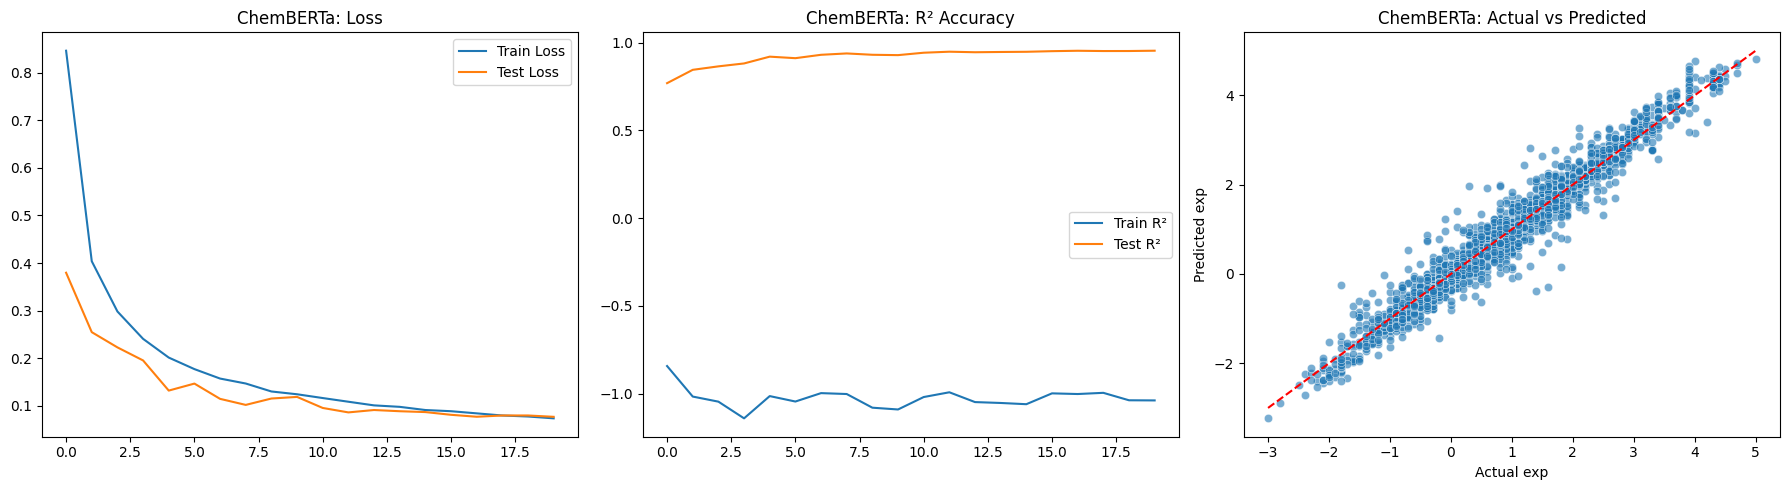

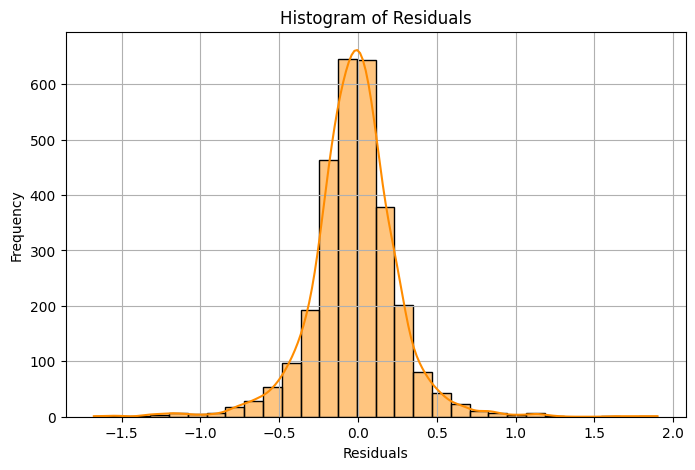

📊 Residual Standard Error (RSE): nan


<ipython-input-3-78acb85eece0>:187: RuntimeWarning: invalid value encountered in sqrt
  rse = np.sqrt(np.sum(residuals**2) / (n - p))


In [ ]:
data = pd.read_csv("logP_synthetic_dataset(1).csv")  # <<< put your path here

# 2. ChemBERTa tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
bert_model = AutoModel.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")

# 3. Custom Dataset
class SMILESDataset(Dataset):
    def __init__(self, smiles, targets, tokenizer, max_length=128):
        self.smiles = smiles
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, idx):
        smile = str(self.smiles[idx])
        target = self.targets[idx]
        encoding = self.tokenizer(smile, padding='max_length', truncation=True,
                                  max_length=self.max_length, return_tensors='pt')
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'target': torch.tensor(target, dtype=torch.float)
        }

# 4. Train / Test Split
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_targets, test_targets = train_test_split(
    data['slimp'],
    data['exp'],
    test_size=0.2,
    random_state=42
)


train_dataset = SMILESDataset(train_texts.tolist(), train_targets.tolist(), tokenizer)
test_dataset = SMILESDataset(test_texts.tolist(), test_targets.tolist(), tokenizer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# 5. Regression Model based on ChemBERTa
class RegressionModel(nn.Module):
    def __init__(self, bert_model):
        super(RegressionModel, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(0.5)
        self.out = nn.Linear(768, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output if hasattr(outputs, 'pooler_output') else outputs.last_hidden_state[:, 0]
        x = self.dropout(pooled_output)
        return self.out(x)

model = RegressionModel(bert_model)

# Fine-tune entire BERT
for param in model.bert.parameters():
    param.requires_grad = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# 6. Optimizer and Scheduler
optimizer = AdamW(model.parameters(), lr=1e-5)
num_training_steps = len(train_loader) * 30

scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

loss_fn = nn.MSELoss()

# 7. Training
epochs = 20
train_losses, test_losses = [], []
train_r2s, test_r2s = [], []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['target'].to(device).view(-1)

        outputs = model(input_ids, attention_mask).view(-1)
        loss = loss_fn(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()

    train_losses.append(train_loss / len(train_loader))

    model.eval()
    test_loss = 0
    preds, true_vals = [], []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['target'].to(device).view(-1)

            outputs = model(input_ids, attention_mask).view(-1)
            loss = loss_fn(outputs, targets)

            test_loss += loss.item()
            preds.extend(outputs.cpu().numpy().reshape(-1))
            true_vals.extend(targets.cpu().numpy().reshape(-1))

    test_losses.append(test_loss / len(test_loader))
    train_r2 = r2_score(train_targets[:len(preds)], preds)
    test_r2 = r2_score(true_vals, preds)
    train_r2s.append(train_r2)
    test_r2s.append(test_r2)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_losses[-1]:.4f} | Test Loss: {test_losses[-1]:.4f} | Test R²: {test_r2:.4f}")

# 8. Final Evaluation
mae = mean_absolute_error(true_vals, preds)
mse = mean_squared_error(true_vals, preds)
rmse = np.sqrt(mse)
r2 = r2_score(true_vals, preds)

print("\n✅ Final Results:")
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")

# 9. Visualizations
plt.figure(figsize=(18,5))

# Loss
plt.subplot(1,3,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('ChemBERTa: Loss')
plt.legend()

# R2 Score
plt.subplot(1,3,2)
plt.plot(train_r2s, label='Train R²')
plt.plot(test_r2s, label='Test R²')
plt.title('ChemBERTa: R² Accuracy')
plt.legend()

# Actual vs Predicted
plt.subplot(1,3,3)
sns.scatterplot(x=true_vals, y=preds, alpha=0.6)
plt.plot([min(true_vals), max(true_vals)], [min(true_vals), max(true_vals)], 'r--')
plt.xlabel('Actual exp')
plt.ylabel('Predicted exp')
plt.title('ChemBERTa: Actual vs Predicted')

plt.tight_layout()
plt.show()

# 10. Residual Analysis
residuals = np.array(true_vals) - np.array(preds)

# Histogram of residuals
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=30, kde=True, color='darkorange')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Residual Standard Error (RSE)
n = len(true_vals)
p = sum(p.numel() for p in model.parameters() if p.requires_grad)
rse = np.sqrt(np.sum(residuals**2) / (n - p))

print(f"📊 Residual Standard Error (RSE): {rse:.4f}")

Experiment Log P datasets

In [4]:
chemin_5 = "logP_experimental_dataset.csv"
df_5 = pd.read_csv(chemin_5)


display(df_5.head(10))

,slimp,exp
0,COc1ccc2c(c1)O[C@@](CC2=O)(C(F)(F)F)O,2.79
1,CC1(O[C@H]([C@H](O1)C(=O)N)C(=O)N)C(C)(C)C,1.60
2,CCOc1cc(cc(c1OCC)OCC)c2nnc(o2)c3ccco3,3.96
3,CN(C)c1ccc(cc1)C(=C)c2ccc(cc2)N(C)C,5.30
4,Cc1ccc(o1)[C@H](C#CC(c2ccccc2)(c3ccccc3)O)O,3.53
5,CC(C)(C)c1cc(n[nH]1)Cc2ccccc2,4.35
6,C[C@H]1C[C@@H](CC(C1)(C)C)NC(=S)NCc2csc3c2cccc3,6.21
7,CCNc1nc(nc(n1)Oc2ccc(nn2)OCC)NC(C)C,3.14
8,c1ccc2c(c1)OCCOCCOCCO2,1.81
9,c1ccc2c(c1)c3c(c(=O)o2)[C@H](C(=C(O3)N)C#N)c4c...,2.34


Epoch 1/20 | Train Loss: 9.1777 | Test Loss: 2.6729 | Test R²: -0.8290
Epoch 2/20 | Train Loss: 1.9490 | Test Loss: 1.1668 | Test R²: 0.1738
Epoch 3/20 | Train Loss: 1.1959 | Test Loss: 1.0896 | Test R²: 0.2298
Epoch 4/20 | Train Loss: 1.0656 | Test Loss: 0.9292 | Test R²: 0.3537
Epoch 5/20 | Train Loss: 0.9144 | Test Loss: 0.9184 | Test R²: 0.3645
Epoch 6/20 | Train Loss: 0.8735 | Test Loss: 0.8386 | Test R²: 0.4278
Epoch 7/20 | Train Loss: 0.8491 | Test Loss: 0.8311 | Test R²: 0.4347
Epoch 8/20 | Train Loss: 0.7599 | Test Loss: 0.8252 | Test R²: 0.4397
Epoch 9/20 | Train Loss: 0.7350 | Test Loss: 0.8987 | Test R²: 0.3862
Epoch 10/20 | Train Loss: 0.6892 | Test Loss: 0.8301 | Test R²: 0.4420
Epoch 11/20 | Train Loss: 0.6835 | Test Loss: 0.8244 | Test R²: 0.4491
Epoch 12/20 | Train Loss: 0.6324 | Test Loss: 0.8264 | Test R²: 0.4463
Epoch 13/20 | Train Loss: 0.6047 | Test Loss: 0.8535 | Test R²: 0.4259
Epoch 14/20 | Train Loss: 0.5956 | Test Loss: 0.8581 | Test R²: 0.4277
Epoch 15/20 | 

IndexError: boolean index did not match indexed array along axis 0; size of axis is 142 but size of corresponding boolean axis is 564

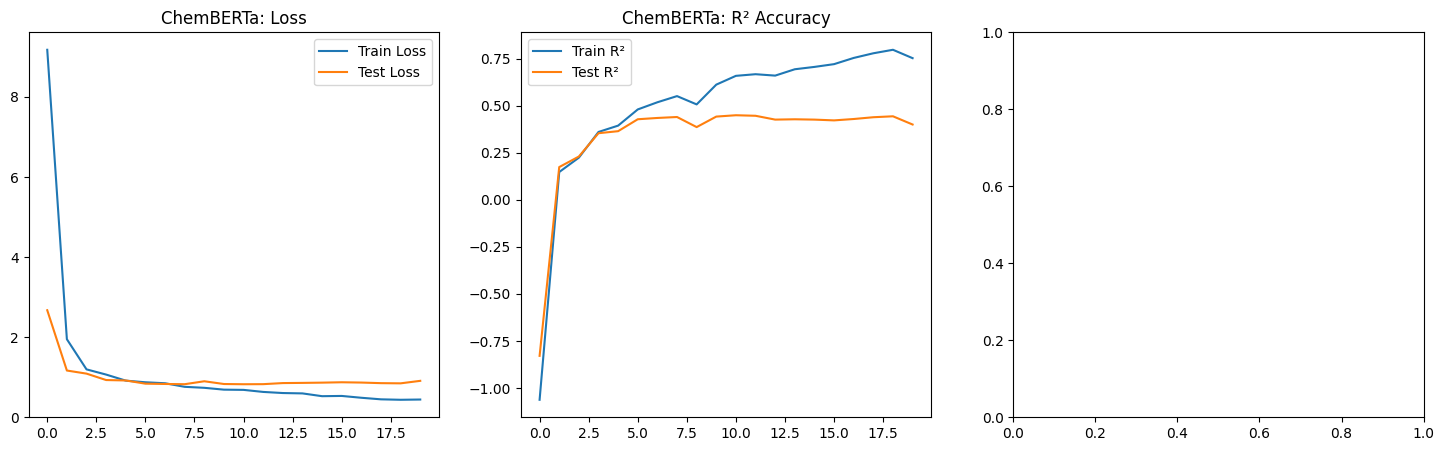

In [10]:
# ✅ 1. Install dependencies if not already installed (Uncomment if needed)
# !pip install transformers torch scikit-learn pandas seaborn matplotlib

# ✅ 2. Import libraries
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
#from transformers import AutoTokenizer, AutoModel, AdamW, get_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ 3. Load and clean data
data = pd.read_csv("logP_experimental_dataset.csv")
data = data.dropna(subset=['slimp', 'exp'])  # Remove rows with NaNs

# ✅ 4. Tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
tokenizer.pad_token = tokenizer.eos_token  # Set pad token
bert_model = AutoModel.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")

# ✅ 5. Custom Dataset
class SMILESDataset(Dataset):
    def __init__(self, smiles, targets, tokenizer, max_length=128):
        self.smiles = smiles
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, idx):
        smile = str(self.smiles[idx])
        target = self.targets[idx]
        encoding = self.tokenizer(smile, padding='max_length', truncation=True,
                                  max_length=self.max_length, return_tensors='pt')
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'target': torch.tensor(target, dtype=torch.float)
        }

# ✅ 6. Split data
train_texts, test_texts, train_targets, test_targets = train_test_split(
    data['slimp'],
    data['exp'],
    test_size=0.2,
    random_state=42
)

train_dataset = SMILESDataset(train_texts.tolist(), train_targets.tolist(), tokenizer)
test_dataset = SMILESDataset(test_texts.tolist(), test_targets.tolist(), tokenizer)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# ✅ 7. Regression Model
class RegressionModel(nn.Module):
    def __init__(self, bert_model):
        super(RegressionModel, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(0.5)
        self.out = nn.Linear(768, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output if hasattr(outputs, 'pooler_output') else outputs.last_hidden_state[:, 0]
        x = self.dropout(pooled_output)
        return self.out(x)

# ✅ 8. Training Setup
model = RegressionModel(bert_model)
for param in model.bert.parameters():
    param.requires_grad = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=1e-5)
num_training_steps = len(train_loader) * 30
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)
loss_fn = nn.MSELoss()

# ✅ 9. Training Loop
epochs = 20
train_losses, test_losses = [], []
train_r2s, test_r2s = [], []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['target'].to(device).view(-1)

        outputs = model(input_ids, attention_mask).view(-1)
        loss = loss_fn(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        train_loss += loss.item()

    train_losses.append(train_loss / len(train_loader))

    model.eval()
    test_loss = 0
    preds, true_vals = [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['target'].to(device).view(-1)

            outputs = model(input_ids, attention_mask).view(-1)
            loss = loss_fn(outputs, targets)

            test_loss += loss.item()
            preds.extend(outputs.cpu().numpy())
            true_vals.extend(targets.cpu().numpy())

    test_losses.append(test_loss / len(test_loader))

    # Clean preds and true_vals
    preds = np.array(preds)
    true_vals = np.array(true_vals)
    mask = ~np.isnan(true_vals) & ~np.isnan(preds)
    test_r2 = r2_score(true_vals[mask], preds[mask])
    test_r2s.append(test_r2)

    # Also compute train R²
    train_preds, train_true = [], []
    with torch.no_grad():
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['target'].to(device).view(-1)
            outputs = model(input_ids, attention_mask).view(-1)
            train_preds.extend(outputs.cpu().numpy())
            train_true.extend(targets.cpu().numpy())

    train_preds = np.array(train_preds)
    train_true = np.array(train_true)
    mask = ~np.isnan(train_true) & ~np.isnan(train_preds)
    train_r2 = r2_score(train_true[mask], train_preds[mask])
    train_r2s.append(train_r2)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_losses[-1]:.4f} | Test Loss: {test_losses[-1]:.4f} | Test R²: {test_r2:.4f}")

# ✅ 10. Final Evaluation
#mae = mean_absolute_error(true_vals[mask], preds[mask])


# 8. Final Evaluation
mae = mean_absolute_error(true_vals, preds)
mse = mean_squared_error(true_vals, preds)
rmse = np.sqrt(mse)
r2 = r2_score(true_vals, preds)
#mse = mean_squared_error(true_vals[mask], preds[mask])
#rmse = np.sqrt(mse)
#r2 = r2_score(true_vals[mask], preds[mask])

# Define a threshold within which predictions are considered "accurate"
accuracy_threshold = 0.5  # or another value depending on your use case

# Convert lists to NumPy arrays
predss = np.array(preds)
true_valss = np.array(true_vals)

# Calculate regression accuracy
accuracy = np.mean(np.abs(predss - true_valss) < accuracy_threshold)




# Calculate regression accuracy
#accuracy = np.mean(np.abs(predss - true_valss) < accuracy_threshold)


print("\n✅ Final Results:")
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")
print(f"Accuracy   : {accuracy:.4f}")


# ✅ 11. Visualization
plt.figure(figsize=(18, 5))

# Loss
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('ChemBERTa: Loss')
plt.legend()

# R2 Score
plt.subplot(1, 3, 2)
plt.plot(train_r2s, label='Train R²')
plt.plot(test_r2s, label='Test R²')
plt.title('ChemBERTa: R² Accuracy')
plt.legend()

# Actual vs Predicted
plt.subplot(1, 3, 3)
#sns.scatterplot(x=true_vals[mask], y=preds[mask], alpha=0.6)
plt.plot([min(true_vals[mask]), max(true_vals[mask])], [min(true_vals[mask]), max(true_vals[mask])], 'r--')
plt.xlabel('Actual exp')
plt.ylabel('Predicted exp')
plt.title('ChemBERTa: Actual vs Predicted')

plt.tight_layout()
plt.show()

# ✅ 12. Residual Analysis
residuals = true_vals[mask] - preds[mask]
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=30, kde=True, color='darkorange')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Residual Standard Error (RSE)
n = len(true_vals[mask])
p = sum(p.numel() for p in model.parameters() if p.requires_grad)
rse = np.sqrt(np.sum(residuals**2) / (n - p))
print(f"📊 Residual Standard Error (RSE): {rse:.4f}")
